In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path

from bart_representation_analysis import *
from bart_compress_visualize_decode import *
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

set_rc()

# Testing code

In [385]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def get_cluster_activations(activ, kmeans=None, k=5):
    '''
    Use kmeans on hidden state data to cluster the data after scaling
    km: if passed, use an already fit KMeans model, rather than fitting a new one
    '''
    data = activ.T  # change to [64, T]
    scaler = TimeSeriesScalerMeanVariance()
    data_normalized = scaler.fit_transform(data[:, :, np.newaxis])  # Shape becomes [64, T, 1]
    data_normalized = data_normalized.squeeze()  # Back to shape [64, T]
    if kmeans is None:
        kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(data_normalized)
    
    cluster_data = [data_normalized[labels == i] for i in range(kmeans.n_clusters)]
    cluster_activations = np.vstack([c.mean(axis=0) for c in cluster_data]).T
    return cluster_activations, labels, kmeans


def find_k_cluster_activations(res):
    imp = get_impulsivity_data(res, load_global=False)
    activ = imp['activ']
    ap = imp['ap'].reshape(-1, 1)
    
    data = activ.T  # change to [64, T]
    scaler = TimeSeriesScalerMeanVariance()
    data_normalized = scaler.fit_transform(data[:, :, np.newaxis])  # Shape becomes [64, T, 1]
    data_normalized = data_normalized.squeeze()  # Back to shape [64, T]

    max_k = 10  # Maximum number of clusters to try
    silhouette_scores = []
    r2_scores = []
    ks = range(2, max_k + 1)

    lr = LinearRegression()
    lr.fit(activ, ap)
    ypred = lr.predict(activ)
    best_r2 = r2_score(ap, ypred)
    
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(data_normalized)
        silhouette_avg = silhouette_score(data_normalized, labels)
        silhouette_scores.append(silhouette_avg)

        # Test how good the cluster compression explains behavior
        cluster_activations, _, _ = get_cluster_activations(activ, kmeans)
        lr = LinearRegression()
        lr.fit(cluster_activations, ap)
        ypred = lr.predict(cluster_activations)
        r2_scores.append(r2_score(ap, ypred))
        
    r2_scores = np.array(r2_scores)
    silhouette_scores = np.array(silhouette_scores)
    
    # Ensure that enough info is kept in clusters to keep r2 prediction high
    min_r2_idx = np.argmax(r2_scores > 0.8*best_r2)
    best_k = np.argmax(silhouette_scores[min_r2_idx:]) + min_r2_idx + 2
    
    return best_k


def train_lasso_with_value_for_impulsivity(res, activ=None, alpha=1e-3, impulsive_thres=0.2):
    '''
    Train a Lasso regression to determine the importance of certain features
    on impulsivity measurements
    impulsive_thres: threshold below which we consider steps impulsive
    activ: optionally pass specific activations, such as cluster activations
    '''
    imp = get_impulsivity_data(res, impulsive_thres=impulsive_thres, load_global=False)
    v = imp['v']
    ap = imp['ap']
    imp_steps = imp['imp_steps']
    if activ is None:
        activ = imp['activ']
    value_estimation = v[imp_steps].reshape(-1)
    impulsivity = ap[imp_steps].reshape(-1)
    activ = activ[imp_steps]
    
    X = np.column_stack((value_estimation, activ))
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled, impulsivity)

    # 4. Identifying Significant Neurons
    # Extract coefficients and feature names
    coefficients = lasso.coef_
    intercept = lasso.intercept_

    # Create a DataFrame for easy interpretation
    feature_names = ['value_estimation'] + [f'activ_{i}' for i in range(activ.shape[1])]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Filter out features with non-zero coefficients
    significant_features = coef_df[coef_df['Coefficient'] != 0]
    return significant_features


def split_by_ep(res, data):
    '''After combining steps, return back to episode based split'''
    ep_lens = [len(o) for o in res['obs']]

    ep_data = []
    cur_step = 0
    for ep_len in ep_lens:
        ep_data.append(data[cur_step:cur_step+ep_len])
        cur_step += ep_len
    return ep_data
    

def visualize_cluster_activations(res, klabels, ep=8, layer='shared1'):
    '''
    Visualize the compositionn of each cluster across a single episode
    '''
    k = np.max(klabels) + 1
    if k > 20:
        print('k > 20, not creating plot')
        return None

    activ = res['activations'][layer][ep]
    cluster_data = [activ[:, klabels == i] for i in range(k)]
    fig, axs = pplt.subplots(nrows=k, sharex=True, sharey=True, 
                             figwidth=5, refaspect=4)
        
    for i, ax in enumerate(axs):
        ax.format(title=f'Cluster {i}')
        
        for j in range(cluster_data[i].shape[1]):
            ax.plot(cluster_data[i][:, j], alpha=0.5)
        ax.plot(cluster_data[i].mean(axis=1), c='black')
    fig.format(suptitle='Time Series Clusters Visualization', xlabel='Time', ylabel='Normalized Value')


def get_size_episode_coverage(res):
    '''
    Get episodes out of the 17 episodes that capture the different sizes the agent
    achieved, to use for visualization rather than using all episodes
    '''
    ep_idxs = []
    kept_means = []
    means = np.array([np.mean(s[-10:]) for s in res['data']['last_size']])
    for ep in range(17):
        if np.all(np.abs(np.array(kept_means) - means[ep]) > 0.02):
            kept_means.append(means[ep])
            ep_idxs.append(ep)
    return ep_idxs
    

def visualize_smoothed_cluster_episodes(res, klabels, layer='shared1',
                                        color_by_mu=False, minimal_size_coverage=False):
    '''
    Visualize how clustered acivations work smoothed across episodes and colored
    by balloon size
    color_by_mu: if True, color lines based on true balloon size, otherwise
        color by the average size the agent achieved on the episode
    minimal_size_coverage: if True, only use as many episodes as needed to see range of 
        sizes achieved
    '''
    k = np.max(klabels) + 1
    if k > 20:
        print('k > 20, not creating plot')
        return None
    fig, ax = pplt.subplots(nrows=k, sharex=True, sharey=False, 
                             figwidth=5, refaspect=4)
    
    if minimal_size_coverage:
        ep_idxs = get_size_episode_coverage(res)
    else:
        ep_idxs = range(17)

    if color_by_mu:
        bsizes = np.arange(0.2, 1.01, 0.05)
        vmin = 0.2
        vmax = 1
    else:
        bsizes = []
        for ep in ep_idxs:
            popped = np.array(res['data']['popped'][ep])
            sizes = np.array(res['data']['last_size'][ep])
            bsizes.append(np.mean(sizes[~popped]))
        vmin = np.min(bsizes)
        vmax = np.max(bsizes) + 0.05
        
    for i in range(k):
        for j, ep in enumerate(ep_idxs):
            s = bsizes[j]
            c = get_color_from_colormap(s, vmin, vmax, to_hex=False) 
            cluster_activ = res['activations'][layer][ep][:, klabels == i].mean(axis=1)
            ax[i].plot(list(pd.Series(cluster_activ).ewm(alpha=0.01).mean()),
                    c=c)

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    cbar = fig.colorbar(sm)
    cbar.set_label(label='$\mu$', rotation=0, labelpad=10)
    ax[0].format(title='RNN Clusters')
    ax.format(xlabel='time step')
    for i in range(k):
        ax[i].format(ylabel=f'Cluster {i+1}')
 
 
def visualize_smoothed_pca_episodes(res, n_components=3, layer='shared1',
                                        color_by_mu=False, minimal_size_coverage=False):
    '''
    Visualize how clustered acivations work smoothed across episodes and colored
    by balloon size
    color_by_mu: if True, color lines based on true balloon size, otherwise
        color by the average size the agent achieved on the episode
    minimal_size_coverage: if True, only use as many episodes as needed to see range of 
        sizes achieved
    '''
    fig, ax = pplt.subplots(nrows=n_components, sharex=True, sharey=False, 
                             figwidth=5, refaspect=4)
    
    if minimal_size_coverage:
        ep_idxs = get_size_episode_coverage(res)
    else:
        ep_idxs = range(17)

    if color_by_mu:
        bsizes = np.arange(0.2, 1.01, 0.05)
        vmin = 0.2
        vmax = 1
    else:
        bsizes = []
        for ep in ep_idxs:
            popped = np.array(res['data']['popped'][ep])
            sizes = np.array(res['data']['last_size'][ep])
            bsizes.append(np.mean(sizes[~popped]))
        vmin = np.min(bsizes)
        vmax = np.max(bsizes) + 0.05
        
    pcas = comb_pca(res, layer)
    for i in range(n_components):
        for j, ep in enumerate(ep_idxs):
            s = bsizes[j]
            c = get_color_from_colormap(s, vmin, vmax, to_hex=False) 
            pca = pcas[ep][:, i]
            ax[i].plot(list(pd.Series(pca).ewm(alpha=0.01).mean()),
                    c=c)

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    cbar = fig.colorbar(sm)
    cbar.set_label(label='$\mu$', rotation=0, labelpad=10)
    ax[0].format(title='RNN PCAs')
    ax.format(xlabel='time step')
    for i in range(n_components):
        ax[i].format(ylabel=f'PCA {i+1}')
        
            
def visualize_episode_values(res, color_by_mu=False, minimal_size_coverage=False):
    if minimal_size_coverage:
        ep_idxs = get_size_episode_coverage(res)
    else:
        ep_idxs = range(17)

    if color_by_mu:
        bsizes = np.arange(0.2, 1.01, 0.05)
        vmin = 0.2
        vmax = 1
    else:
        bsizes = []
        for ep in ep_idxs:
            popped = np.array(res['data']['popped'][ep])
            sizes = np.array(res['data']['last_size'][ep])
            bsizes.append(np.mean(sizes[~popped]))
        vmin = np.min(bsizes)
        vmax = np.max(bsizes) + 0.05
        
    fig, ax = pplt.subplots()
    for j, ep in enumerate(ep_idxs):
        s = bsizes[j]
        c = get_color_from_colormap(s, vmin, vmax, to_hex=False)
        ax.plot(list(pd.Series(res['values'][ep].reshape(-1)).ewm(alpha=0.1).mean()), 
                c=c, alpha=0.5)
    print(bsizes)
    ax.format(xlabel='time step', ylabel='Value prediction')
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    cbar = fig.colorbar(sm)
    cbar.set_label(label='$\mu$', rotation=0, labelpad=10)

In [39]:
size = np.arange(0.2, 1.01, 0.05)
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0,
                            'fix_sizes': [0, s, 0]} for s in size]

evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)

In [40]:

model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p1.5n50_2/150.pt') #Agent A
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p1.5n50_1/150.pt') #Agent B
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p2.0n50pop0.1_2/240.pt') #Agent C
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p1.5n50pop0.1_2/50.pt') #Agent C
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p1.7n50pop0.1_1/100.pt') #Agent C
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=50)
# plot_1colornfsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


[0.16428571428571434, 0.2078125, 0.2055555555555556, 0.2961538461538461, 0.3578947368421052, 0.3855263157894737, 0.4605263157894736, 0.49390243902439024, 0.5011363636363636, 0.501, 0.502, 0.5010204081632652, 0.512, 0.498, 0.5139999999999999, 0.5139999999999999, 0.507]


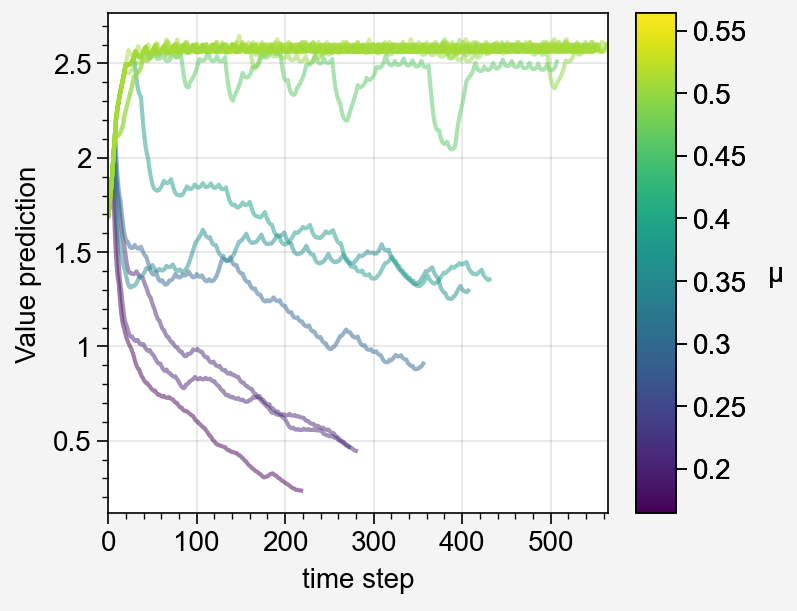

In [4]:
visualize_episode_values(res)

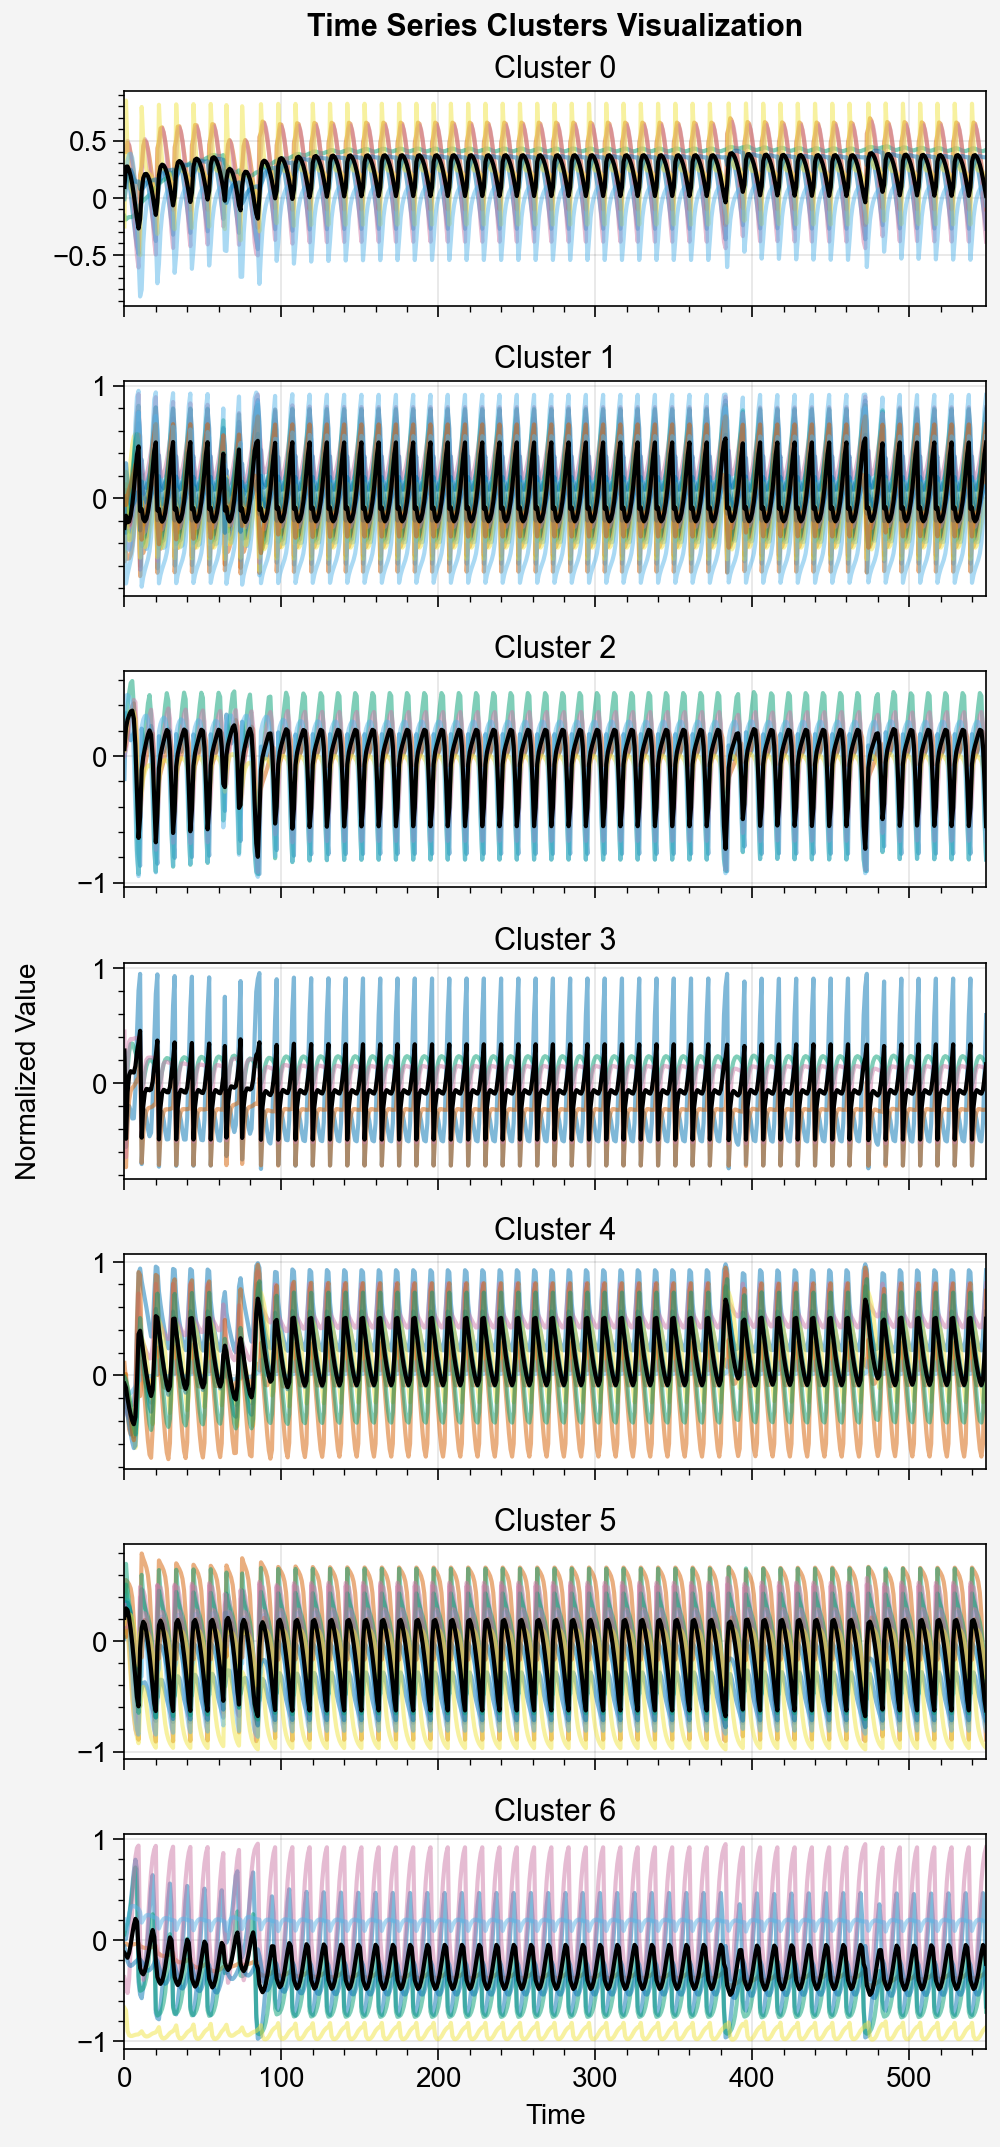

In [5]:
k = find_k_cluster_activations(res)
imp = get_impulsivity_data(res)
activ = imp['activ']
cluster_activ, labels, kmeans = get_cluster_activations(activ, k=k)
feature_importances = train_lasso_with_value_for_impulsivity(res, cluster_activ)
ep_cact = split_by_ep(res, cluster_activ)
visualize_cluster_activations(res, labels)

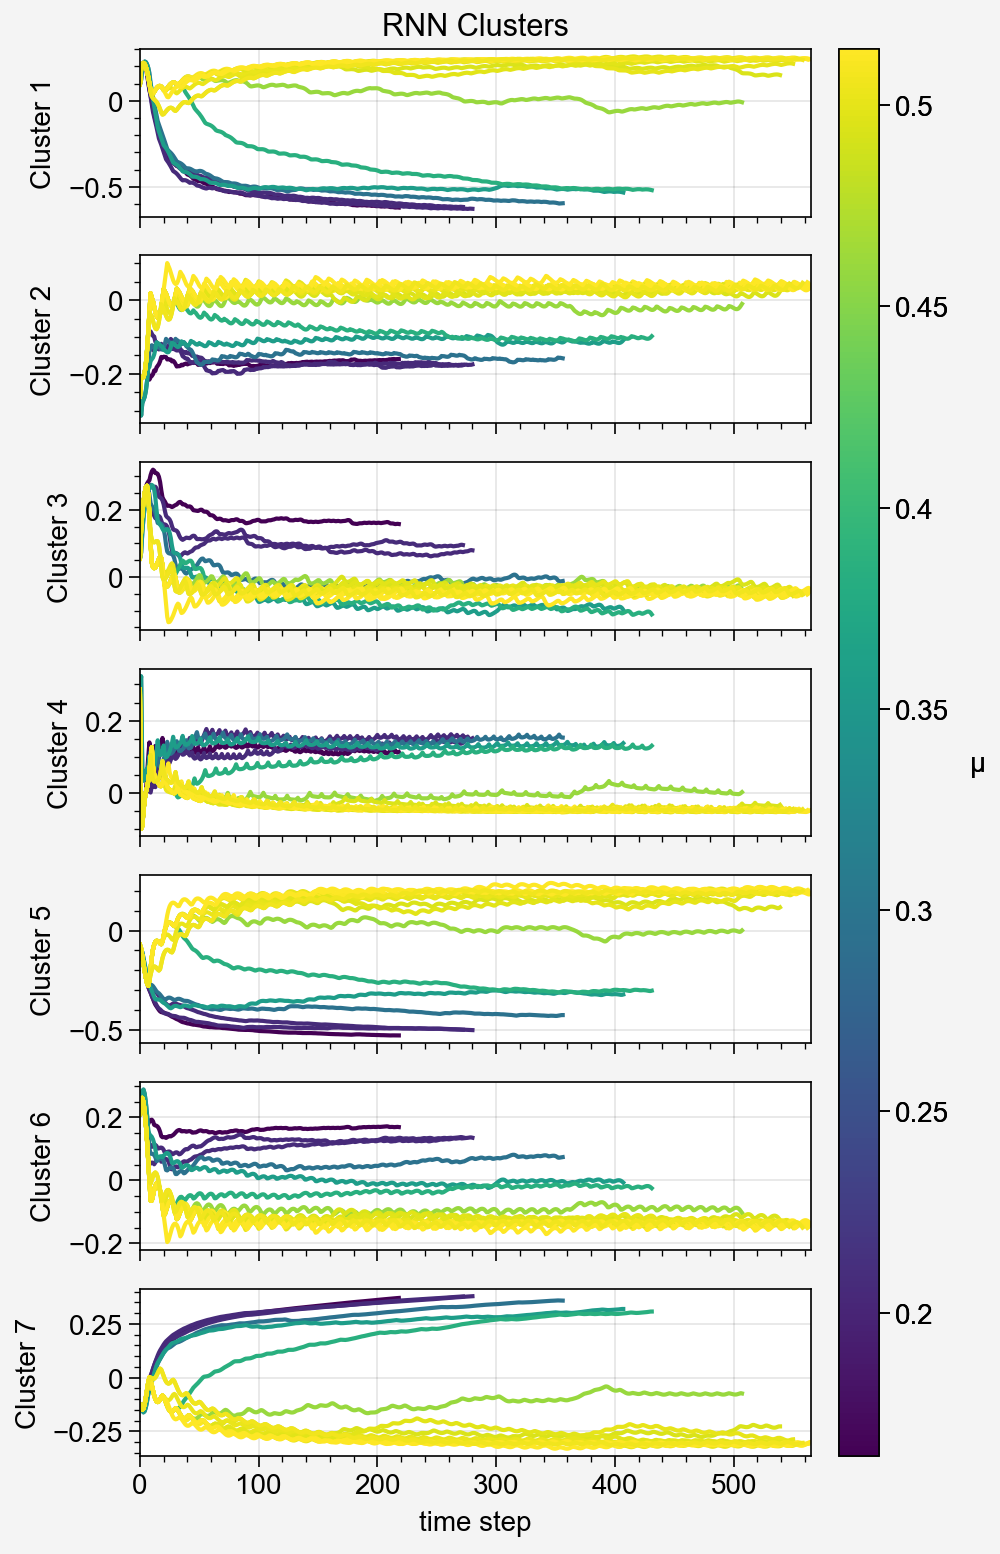

In [ ]:
visualize_smoothed_cluster_episodes(res, labels)

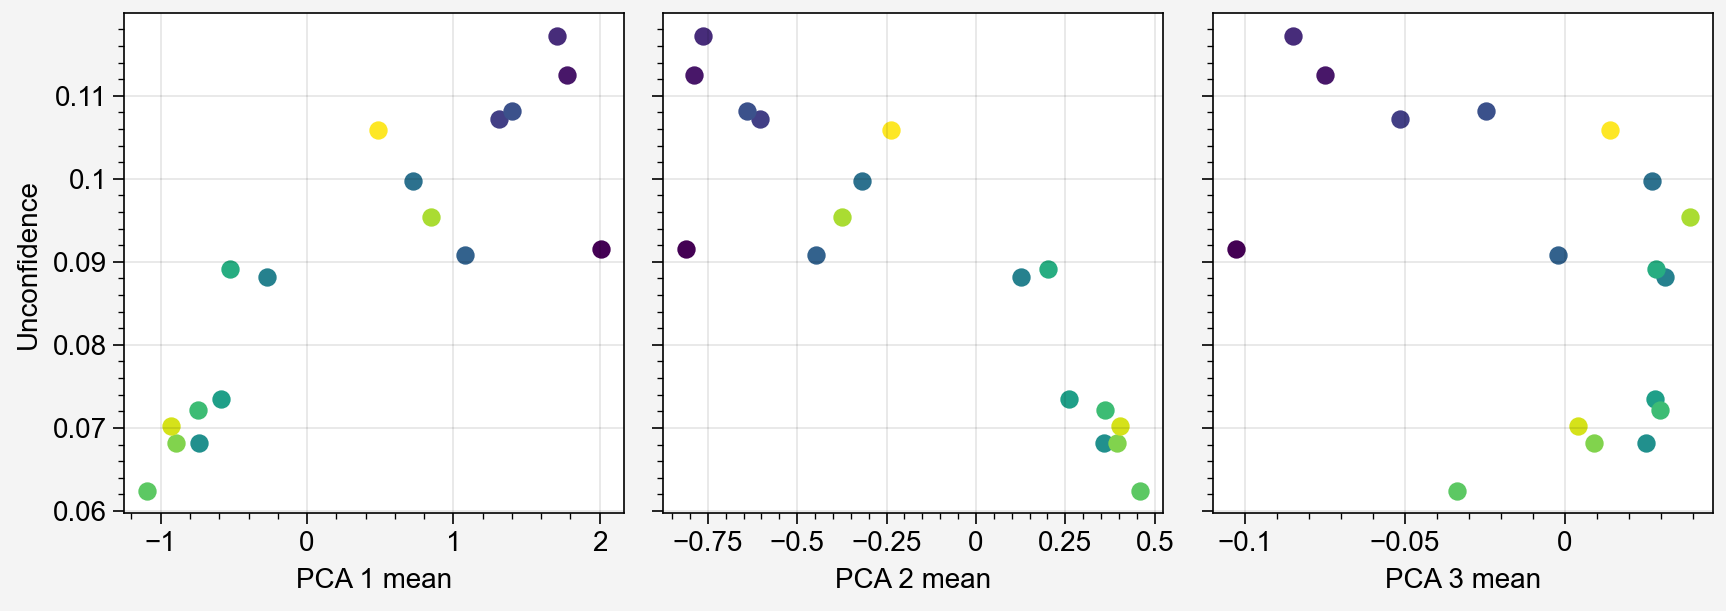

In [600]:
pcas = comb_pca(res)
unc = []
pca_scores = []
for ep in range(17):
    unc.append(score_unconfidence(res, ep))
for i in range(3):
    pca_score = []
    for ep in range(17):
        pca_score.append(pcas[ep][:, i].mean())
    pca_scores.append(pca_score)

fig, ax = pplt.subplots(ncols=3, sharex=False)
for i in range(3):
    for ep in range(17):
        s = balloon_sizes[ep]
        c = get_color_from_colormap(s, 0.2, 1, to_hex=False)
        ax[i].scatter(pca_scores[i][ep], unc[ep], c=c)
        
    ax[i].format(xlabel=f'PCA {i+1} mean')
ax.format(ylabel='Unconfidence')

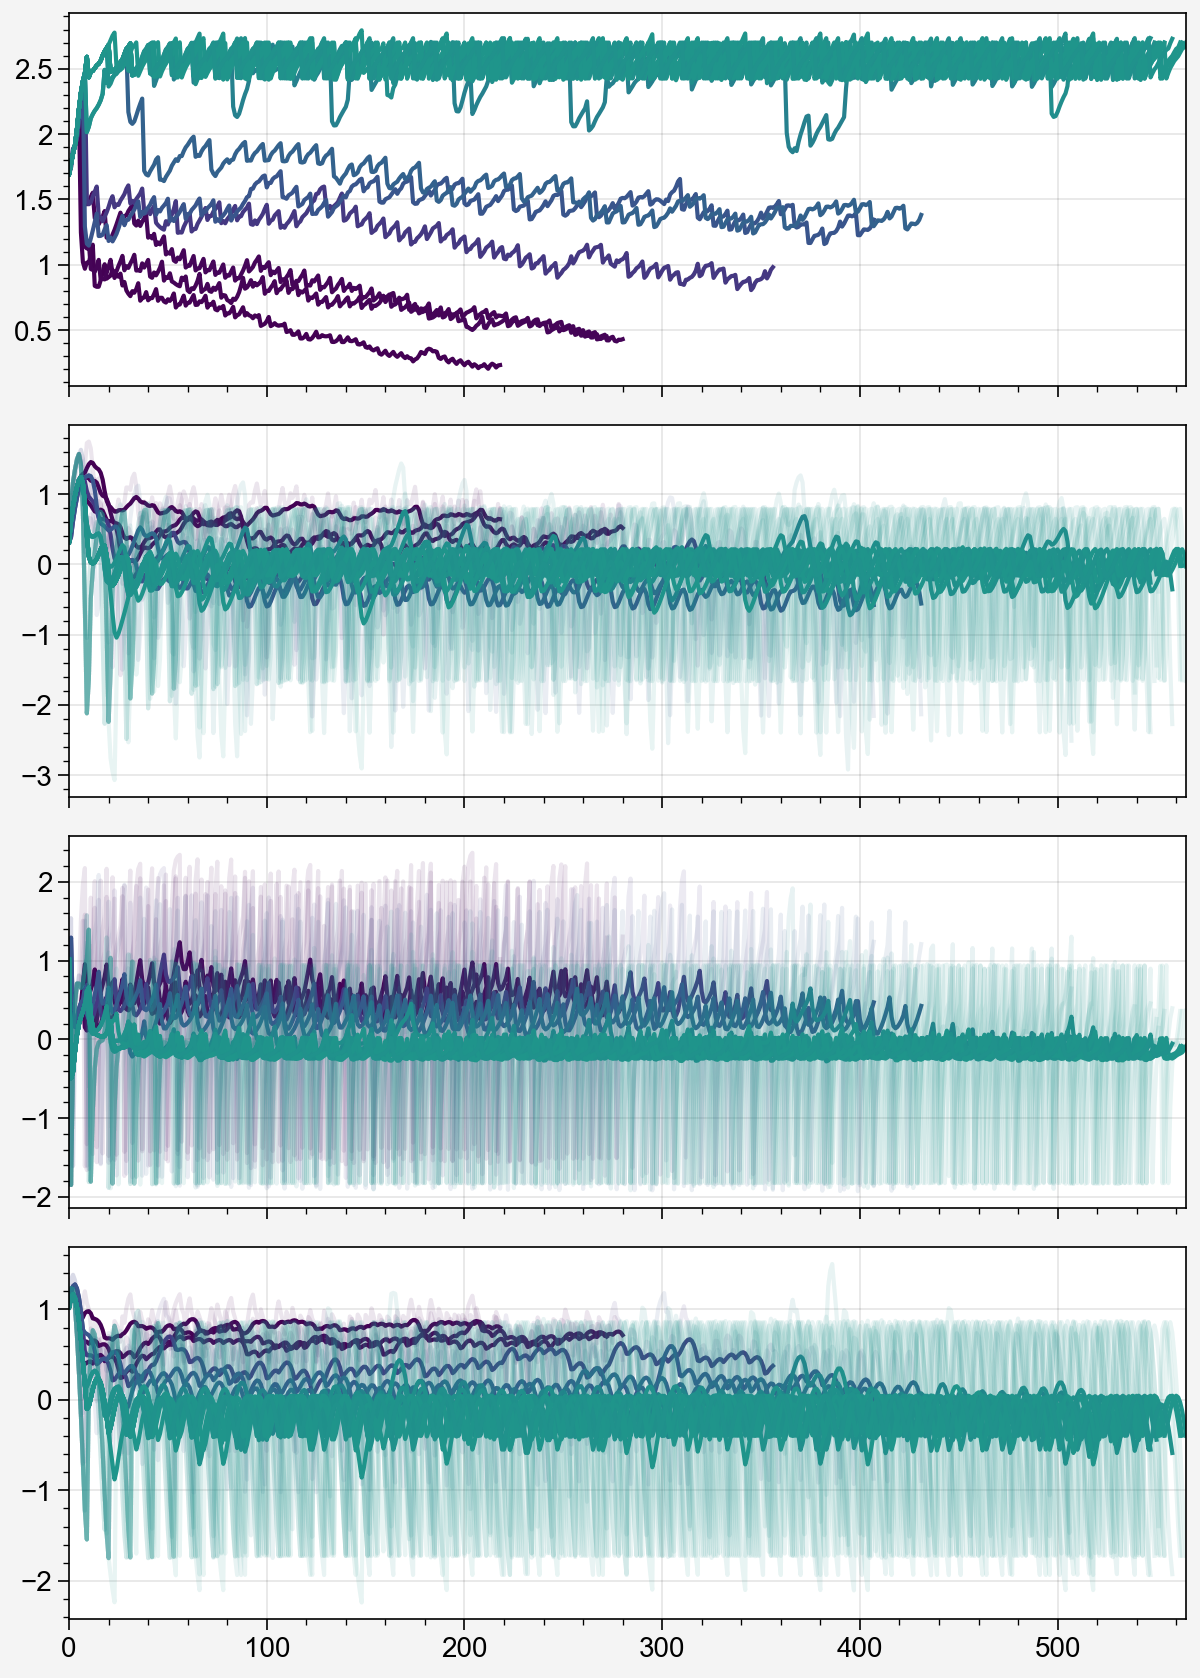

In [304]:
fig, ax = pplt.subplots(nrows=4, refaspect=3, figwidth=6)

plot_clusters = [2, 3, 5]

for ep in range(17):
    popped = np.array(res['data']['popped'][ep])
    sizes = np.array(res['data']['last_size'][ep])
    s = np.mean(sizes[~popped])
    c = get_color_from_colormap(s, 0.2, 0.8, to_hex=False)
    ax[0].plot(res['values'][ep], c=c)
    for i in range(3):
        clus = plot_clusters[i]
        ax[i+1].plot(ep_cact[ep][:, clus], c=c, alpha=0.1)
        smoothed = list(pd.Series(list(ep_cact[ep][:, clus])).ewm(alpha=0.1).mean())
        ax[i+1].plot(smoothed, c=c)

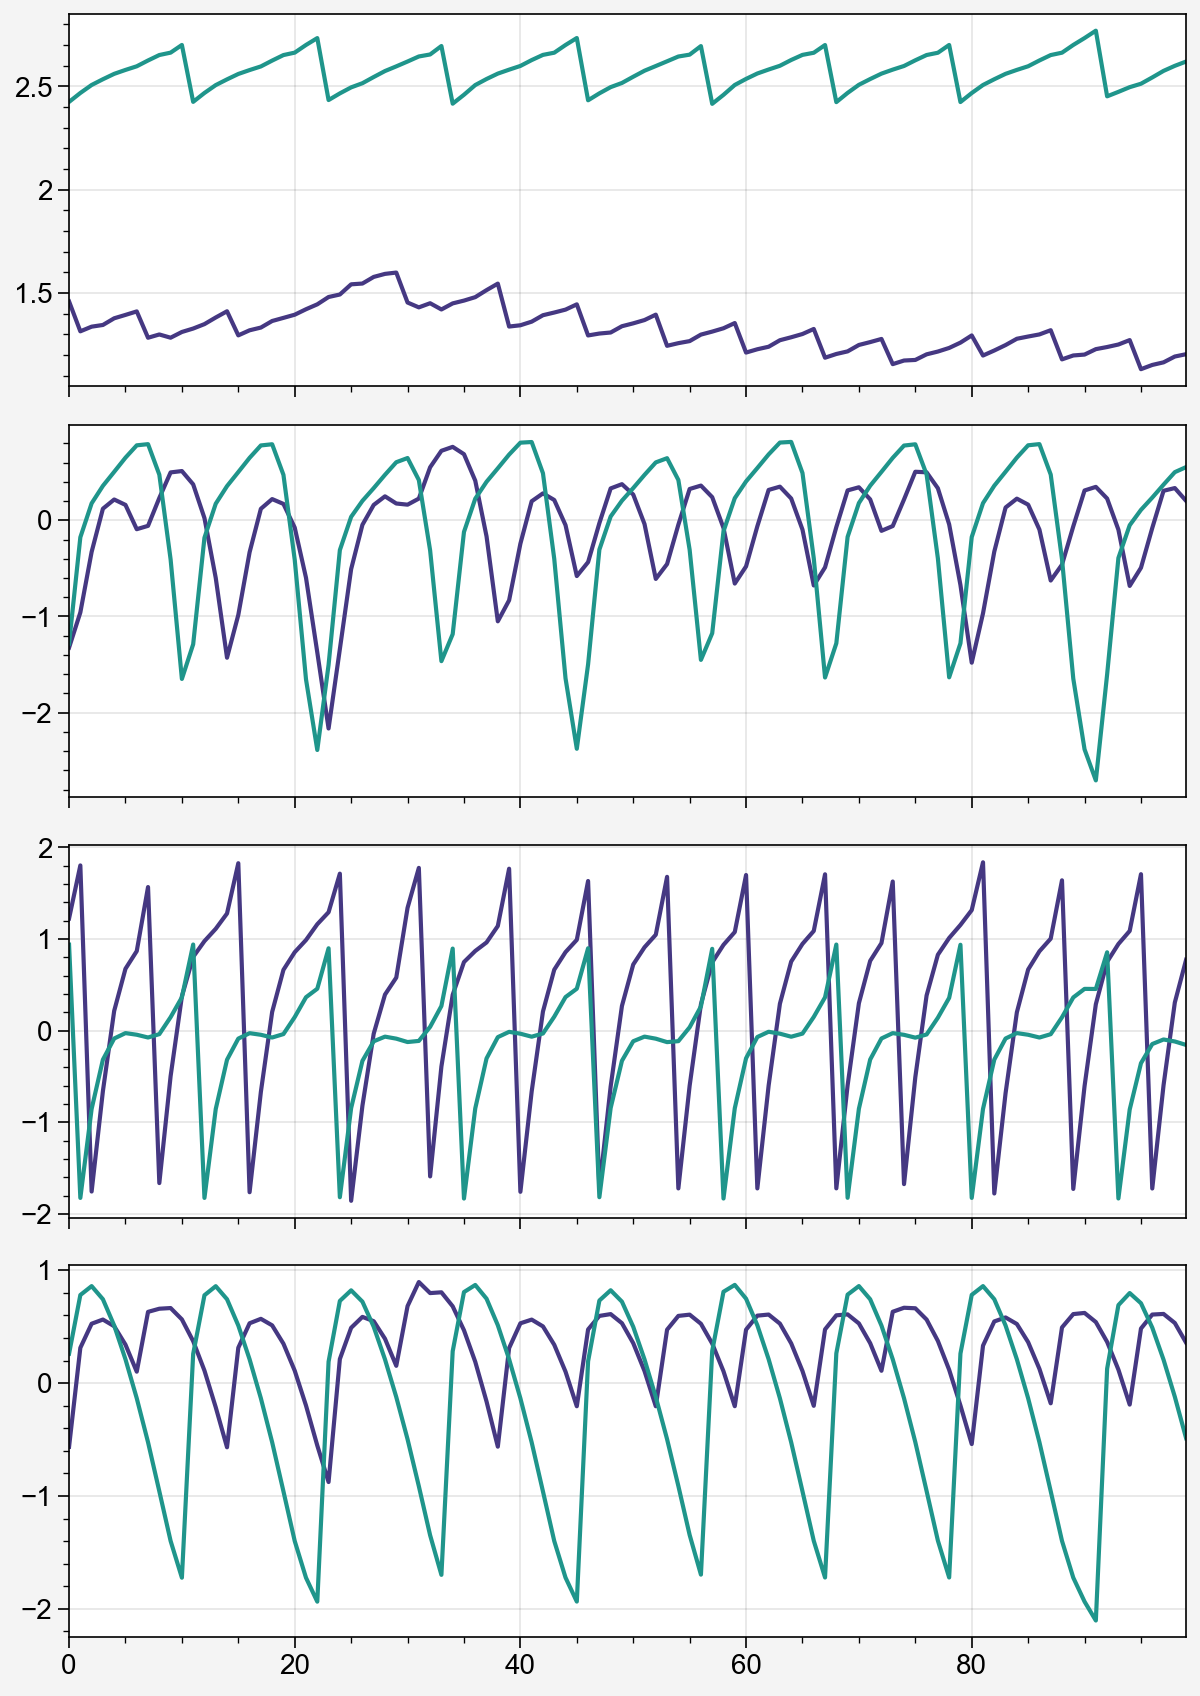

In [310]:
fig, ax = pplt.subplots(nrows=4, refaspect=3, figwidth=6)

plot_clusters = [2, 3, 5]


for ep in [3, 15]:
    popped = np.array(res['data']['popped'][ep])
    sizes = np.array(res['data']['last_size'][ep])
    s = np.mean(sizes[~popped])
    c = get_color_from_colormap(s, 0.2, 0.8, to_hex=False)
    ax[0].plot(res['values'][ep][100:200], c=c)
    for i in range(3):
        clus = plot_clusters[i]
        ax[i+1].plot(ep_cact[ep][100:200, clus], c=c, alpha=1)
        # smoothed = list(pd.Series(list(ep_cact[ep][100:200, clus])).ewm(alpha=0.1).mean())
        # ax[i+1].plot(smoothed, c=c)

In [120]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

imp = get_impulsivity_data(res)
value_estimation = v[imp_steps].reshape(-1)
hidden_states = activ[imp_steps]
impulsivity = ap[imp_steps].reshape(-1)
# Combine value_estimation and hidden_states into a feature matrix
X = np.column_stack((value_estimation, hidden_states))
# 1. Transpose Hidden States
# Shape: (n_neurons, n_samples)
hidden_states_T = hidden_states.T

# 2. Feature Scaling for Clustering
# Standardize neuron activation patterns
scaler = StandardScaler()
hidden_states_scaled = scaler.fit_transform(hidden_states_T)

# 3. Clustering Neurons
# Choose the number of clusters (k)
k = 4  # Adjust based on data analysis
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(hidden_states_scaled)

# 4. Aggregating Cluster Activations
# Initialize cluster activations matrix
cluster_activations = np.zeros((hidden_states.shape[0], k))

for cluster_idx in range(k):
    # Indices of neurons in the current cluster
    neuron_indices = np.where(clusters == cluster_idx)[0]
    # Mean activation of the cluster at each time step
    cluster_activations[:, cluster_idx] = hidden_states[:, neuron_indices].mean(axis=1)

# Cluster feature names
cluster_feature_names = [f'cluster_{i}' for i in range(k)]

# 5. Regression Analysis Including Clusters
# Combine value_estimation and cluster_activations
X = np.column_stack((value_estimation, cluster_activations))
feature_names = ['value_estimation'] + cluster_feature_names

# Add a constant term for intercept
X_with_const = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(impulsivity, X_with_const)
results = model.fit()

# 6. Identifying Significant Clusters
# Create a summary table
summary_table = pd.DataFrame({
    'Feature': ['Intercept'] + feature_names,
    'Coefficient': results.params,
    'P-value': results.pvalues
})

print("Regression Results:")
print(summary_table)

# Identify significant clusters (e.g., p-value < 0.05)
significant_clusters = summary_table[(summary_table['P-value'] < 0.05) & (summary_table['Feature'].str.contains('cluster'))]

print("\nSignificant Clusters:")
print(significant_clusters)

Regression Results:
            Feature  Coefficient        P-value
0         Intercept     0.117333  1.342427e-267
1  value_estimation    -0.041096  2.073085e-139
2         cluster_0     0.020060   1.698687e-14
3         cluster_1    -0.256340  9.135213e-144
4         cluster_2    -0.182171  4.769964e-186
5         cluster_3     0.008576   2.171073e-02

Significant Clusters:
     Feature  Coefficient        P-value
2  cluster_0     0.020060   1.698687e-14
3  cluster_1    -0.256340  9.135213e-144
4  cluster_2    -0.182171  4.769964e-186
5  cluster_3     0.008576   2.171073e-02


In [133]:
X = cluster_activations
y = value_estimation.reshape(-1, 1)
X_with_const = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X_with_const)
results = model.fit()

feature_names = cluster_feature_names
# 6. Identifying Significant Clusters
# Create a summary table
summary_table = pd.DataFrame({
    'Feature': ['Intercept'] + feature_names,
    'Coefficient': results.params,
    'P-value': results.pvalues
})

print("Regression Results:")
print(summary_table)
significant_clusters = summary_table[(summary_table['P-value'] < 0.05) & (summary_table['Feature'].str.contains('cluster'))]

print("\nSignificant Clusters:")
print(significant_clusters)


Regression Results:
     Feature  Coefficient        P-value
0  Intercept     1.880510   0.000000e+00
1  cluster_0     1.309221   0.000000e+00
2  cluster_1    -1.804382  1.902666e-123
3  cluster_2    -1.820053   0.000000e+00
4  cluster_3    -1.017727  2.445957e-282

Significant Clusters:
     Feature  Coefficient        P-value
1  cluster_0     1.309221   0.000000e+00
2  cluster_1    -1.804382  1.902666e-123
3  cluster_2    -1.820053   0.000000e+00
4  cluster_3    -1.017727  2.445957e-282


In [184]:
lm = Lasso(alpha=1e-3)

# X = np.column_stack((value_estimation, cluster_activations))
X = np.column_stack((value_estimation, hidden_states))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = impulsivity.reshape(-1, 1)

lm.fit(X_scaled, y)
print(lm.intercept_)
print(lm.coef_)

[0.00737657]
[-0.          0.         -0.00560222  0.         -0.00502008 -0.
  0.         -0.00497191  0.          0.         -0.         -0.
 -0.         -0.          0.          0.          0.00209773  0.
  0.         -0.         -0.         -0.         -0.         -0.
  0.          0.         -0.00325301 -0.         -0.         -0.
  0.          0.          0.          0.         -0.          0.
 -0.          0.00573047 -0.          0.00205557 -0.          0.
 -0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.         -0.          0.          0.
  0.         -0.00938826 -0.00065129 -0.         -0.         -0.
 -0.          0.          0.         -0.          0.        ]


In [116]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# 1. Data Preparation
# Assuming you have the data as specified:
# impulsivity, value_estimation, hidden_states


imp = get_impulsivity_data(res)
value_estimation = v[imp_steps].reshape(-1)
hidden_states = activ[imp_steps]
impulsivity = ap[imp_steps].reshape(-1)
# Combine value_estimation and hidden_states into a feature matrix
X = np.column_stack((value_estimation, hidden_states))

# Feature names for reference
feature_names = ['value_estimation'] + [f'neuron_{i}' for i in range(hidden_states.shape[1])]

# 2. Feature Scaling
# Standardize features to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Model Fitting with LASSO Regularization
# Use LassoCV to select the best alpha (regularization strength) via cross-validation
lasso = LassoCV(cv=5, random_state=0, max_iter=10000, tol=0.1)
lasso.fit(X_scaled, impulsivity)

# 4. Identifying Significant Neurons
# Extract coefficients and feature names
coefficients = lasso.coef_
intercept = lasso.intercept_

# Create a DataFrame for easy interpretation
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Filter out features with non-zero coefficients
significant_features = coef_df[coef_df['Coefficient'] != 0]
print('R2', r2_score(impulsivity, lasso.predict(X_scaled)))
print('Alpha', lasso.alpha_)

R2 0.7060261157146773
Alpha 4.089228743100292e-05


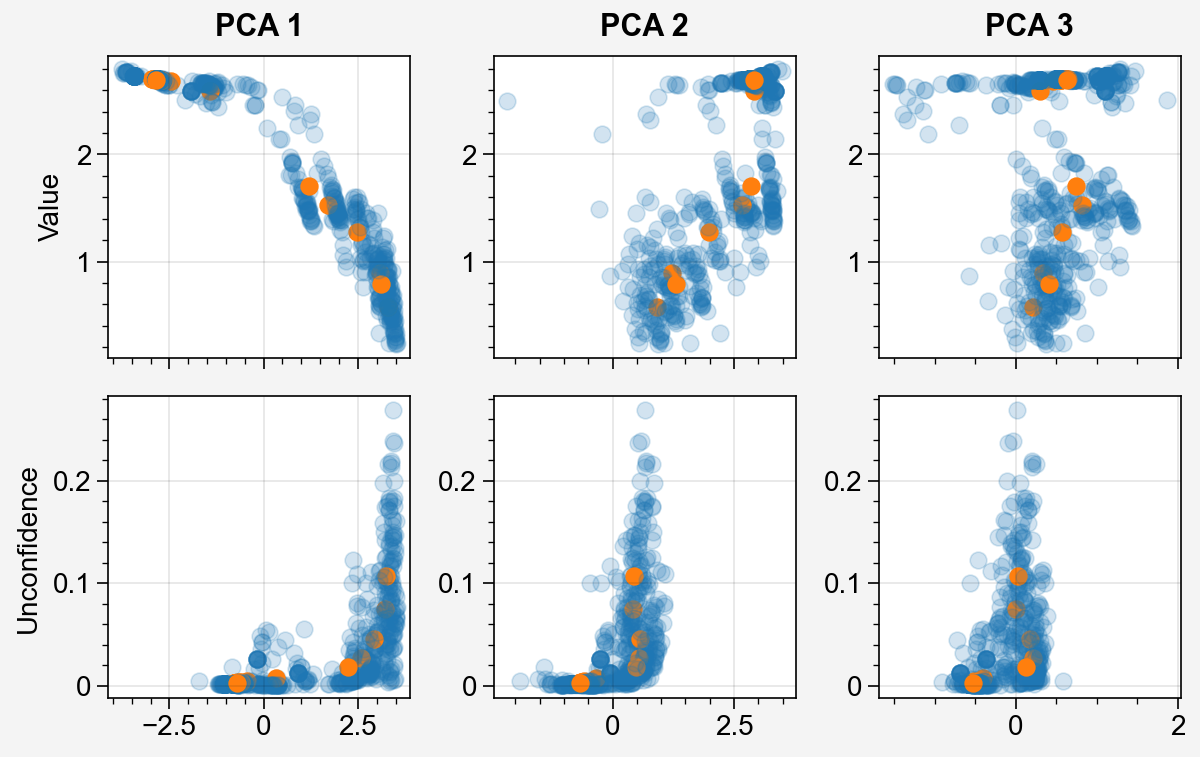

In [944]:
fig, ax = pplt.subplots(ncols=3, nrows=2, figwidth=6, sharey=False)
pcas = comb_pca(res)

for i in range(3):
    for ep in range(17):
        bsteps = np.array(res['data']['balloon_step'][ep])
        v = res['values'][ep].reshape(-1)[bsteps]
        a = pcas[ep][bsteps, i]
        ap = res['action_probs'][ep][:, 1]
        f = 0
        unc_groups = []
        a_groups = []
        for j in range(len(bsteps)):
            rng = np.arange(f, bsteps[j])
            idxs = rng[ap[rng] < 0.5]
            unc_groups.append(ap[idxs].mean())
            a_groups.append(pcas[ep][idxs, i].mean())
            f = bsteps[j]
        ax[0, i].scatter(a, v, alpha=0.2, c=rgb_colors[0])
        ax[0, i].scatter(a.mean(), v.mean(), c=rgb_colors[1])
        ax[1, i].scatter(a_groups, unc_groups,  alpha=0.2, c=rgb_colors[0])
        ax[1, i].scatter(np.mean(a_groups), np.mean(unc_groups), c=rgb_colors[1])
        
ax.format(toplabels=[f'PCA {i+1}' for i in range(3)])
ax[0, 0].format(ylabel='Value')
ax[1, 0].format(ylabel='Unconfidence')

<a list of 1 Line2D objects>

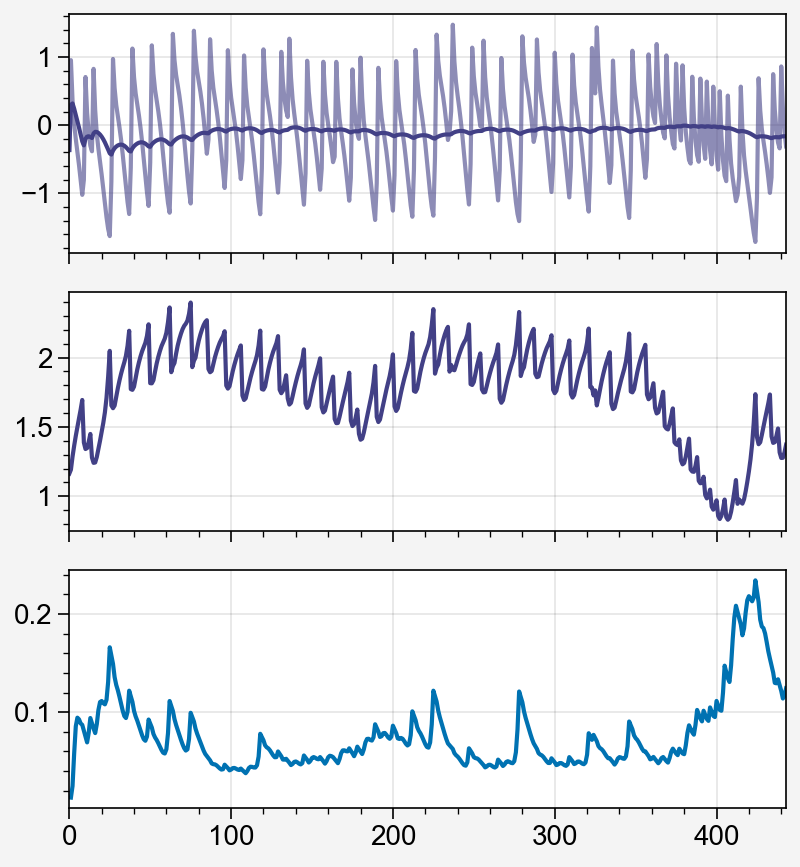

In [763]:

fig, ax = pplt.subplots(nrows=3, refaspect=3, figwidth=4, sharey=False)

balloon_sizes = np.arange(0.2, 1.01, 0.05)
pcas = comb_pca(res)
ep = 7
popped = np.array(res['data']['popped'][ep])
sizes = np.array(res['data']['last_size'][ep])
s = np.mean(sizes[~popped])
c = get_color_from_colormap(s, 0.2, 0.8, to_hex=False)
p = 1
ax[0].plot(pcas[ep][:, p], c=c, alpha=0.6)
ax[0].plot(pd.Series(pcas[ep][:, p]).ewm(alpha=0.01).mean(),
            c=c)
ax[1].plot(res['values'][ep].reshape(-1), c=c)

aps = res['action_probs'][ep][:, 1]
non_presses = aps < .5
steps = np.arange(len(aps))
npsteps = steps[non_presses]
npap = aps[non_presses]
npap = pd.Series(npap).ewm(alpha=0.1).mean()

ax[2].plot(npsteps, npap)

In [ ]:
layer = 'shared1'

# Perform kmeans on the activities of shared layer
k = find_k_cluster_activations(res, layer=layer)
cluster_activ, labels, kmeans = get_cluster_activations(res, layer=layer, k=k)
# Scale new cluster compressed activations
scaler = TimeSeriesScalerMeanVariance()
cluster_norm = scaler.fit_transform(cluster_activ[:, :, np.newaxis])
cluster_norm = cluster_norm.reshape(cluster_activ.shape)
# Set up data
actions = np.vstack(res['actions'])
imp = get_impulsivity_data(res, layer=layer, load_global=False)
values = imp['v']
activ = imp['activ']
ap = imp['ap']
imp_steps = imp['imp_steps']
impuls = ap[imp_steps]
impuls = np.log(impuls)
comb_activ = np.hstack([values, cluster_norm])

# Measure coefficient importances for each cluster of activity

# Decision ramp model
act_model = LogisticRegression(penalty='l1', solver='liblinear', C=0.001)
act_model.fit(cluster_norm, actions)
ypred = act_model.predict(cluster_norm)
# print('F1', f1_score(actions.reshape(-1), ypred))
act_coef = lm.coef_[0]

# Value model
val_model = Lasso(alpha=0.01)
val_model.fit(cluster_norm, values)
ypred = val_model.predict(cluster_norm)
# print('MSE', root_mean_squared_error(values, ypred), 'R2', r2_score(values, ypred))
val_coef = val_model.coef_

# Impulsivity model
lasso = LassoCV(cv=10, random_state=0, max_iter=100000, tol=0.001,
                alphas=np.logspace(-1, 0, 100))
lasso.fit(cluster_norm[imp_steps, :], impuls)
ypred = lasso.predict(cluster_norm[imp_steps, :])
# print('MSE', root_mean_squared_error(imp, ypred), 'R2', r2_score(imp, ypred))
# print('alpha', lasso.alpha_)
imp_coef = lasso.coef_

# Impulsivity as general characteristic

In [60]:
give_rew = ['', 'giverew_']
postfixes = ['', 'pop0.05', 'pop0.1', 'pop0.2']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = np.arange(10, 243, 30)

give_labels = ['Rew not shown', 'Rew shown']
pop_labels = ['0', '-0.05', '-0.1', '-0.2']
pop_vals = [0, -0.05, -0.1, -0.2]
p_labels = ['1.0',' 1.2', '1.5', '1.7', '2.0']
chk_labels = [str(c) for c in chks]
chk_axis = 'Checkpoint'
pop_axis = 'Punishment on pop'
p_axis = 'p'

iterators = [give_rew, postfixes, models, trials, chks]
# iterators = [postfixes, models, trials, chks]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

res = pickle.load(open('data/meta_representation_results', 'rb'))

def metabart_model_load(h, i, j, k, l):
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    chk = chks[l]
    
    if h == 1 and postfix == '':
        postfix = 'pop0'
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')

    return model, obs_rms

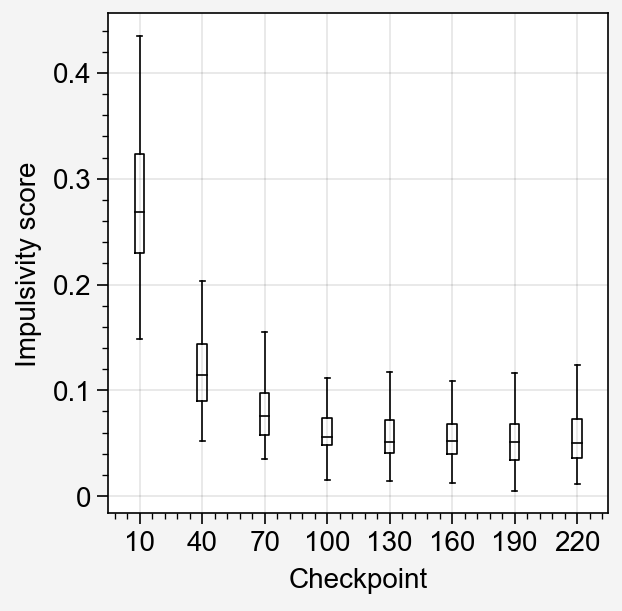

In [61]:
imp_scores = res['unconfidence_scores']
chks = np.arange(10, 243, 30)
fig, ax = pplt.subplots()
for i in range(8):
    ax.boxplot(i, imp_scores[:, :, :, :, i].reshape(-1), fliers=False)
ax.format(xlabel='Checkpoint', xlocator=range(8), xformatter=[str(c) for c in chks],
          ylabel='Impulsivity score')

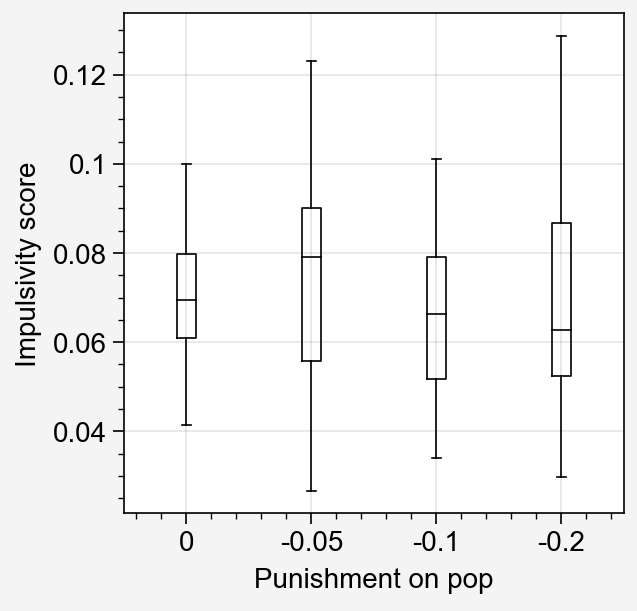

In [65]:
imp_scores = res['unconfidence_scores']
imp_scores = select_idxs(imp_scores, 'first')
fig, ax = pplt.subplots()

for i in range(4):
    ax.boxplot(i, imp_scores[:, i, :, :].reshape(-1), fliers=False)
ax.format(xlabel='Punishment on pop', xlocator=range(4), xformatter=['0',  '-0.05', '-0.1', '-0.2'],
          ylabel='Impulsivity score')

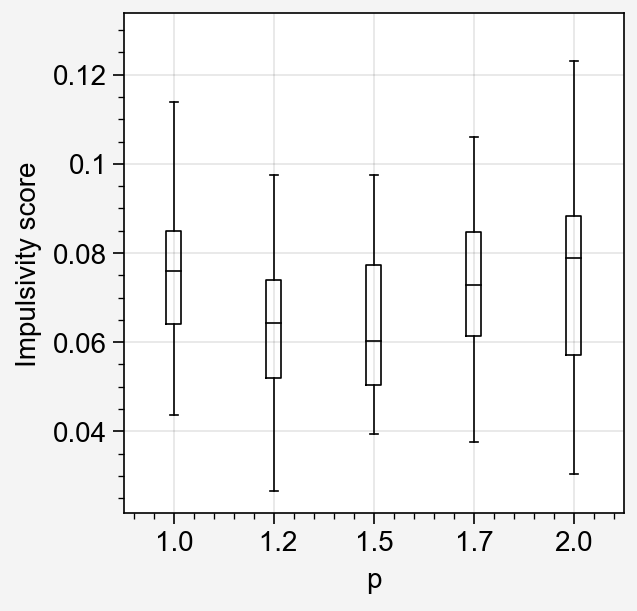

In [67]:
imp_scores = res['unconfidence_scores']
imp_scores = select_idxs(imp_scores, 'first')
fig, ax = pplt.subplots()

for i in range(5):
    ax.boxplot(i, imp_scores[:, :, i, :].reshape(-1), fliers=False)
ax.format(xlabel=p_axis, xlocator=range(5), xformatter=p_labels,
          ylabel='Impulsivity score')

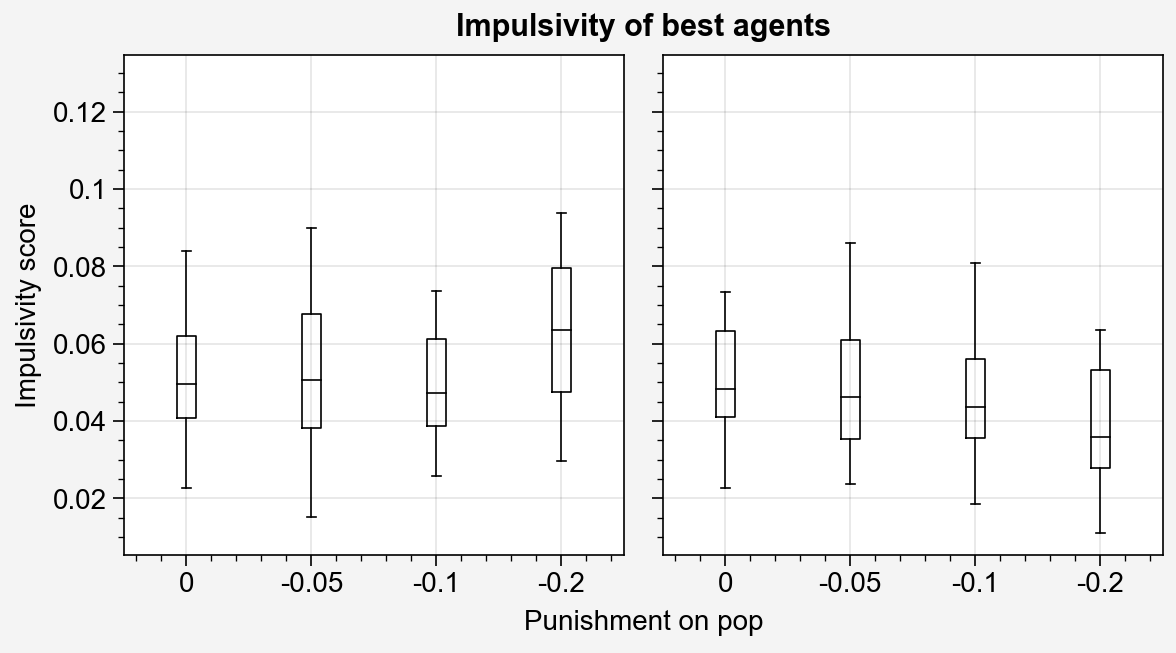

In [20]:
imp_scores = res['unconfidence_scores']
imp_scores = select_idxs(imp_scores)
fig, ax = pplt.subplots(ncols=2)
for h in range(2):
    for i in range(4):
        ax[h].boxplot(i, imp_scores[h, i, :, :].reshape(-1), fliers=False)
ax.format(xlabel='Punishment on pop', xlocator=range(4), xformatter=['0',  '-0.05', '-0.1', '-0.2'],
          ylabel='Impulsivity score', suptitle='Impulsivity of best agents')

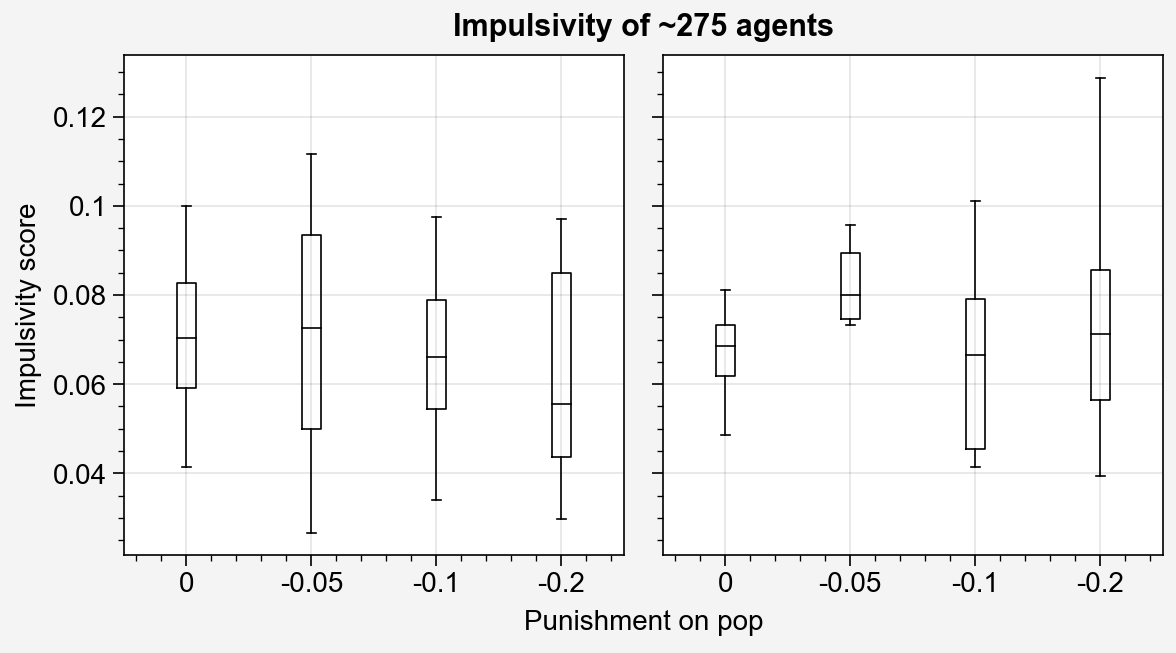

In [66]:
imp_scores = res['unconfidence_scores']
imp_scores = select_idxs(imp_scores, 'first')
fig, ax = pplt.subplots(ncols=2)
for h in range(2):
    for i in range(4):
        ax[h].boxplot(i, imp_scores[h, i, :, :].reshape(-1), fliers=False)
ax.format(xlabel='Punishment on pop', xlocator=range(4), xformatter=['0',  '-0.05', '-0.1', '-0.2'],
          ylabel='Impulsivity score', suptitle='Impulsivity of ~275 agents')

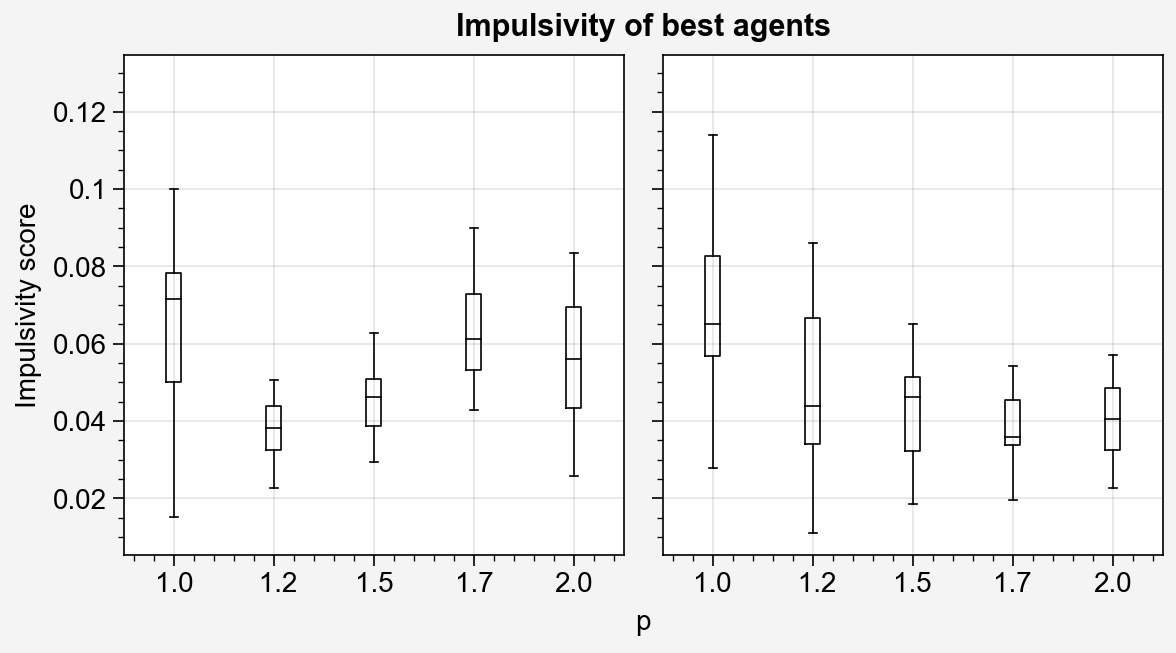

In [19]:
imp_scores = res['unconfidence_scores']
imp_scores = select_idxs(imp_scores)
fig, ax = pplt.subplots(ncols=2)
for h in range(2):
    for j in range(5):
        ax[h].boxplot(j, imp_scores[h, :, j, :].reshape(-1), fliers=False)
ax.format(xlabel=p_axis, xlocator=range(5), xformatter=p_labels,
          ylabel='Impulsivity score', suptitle='Impulsivity of best agents')

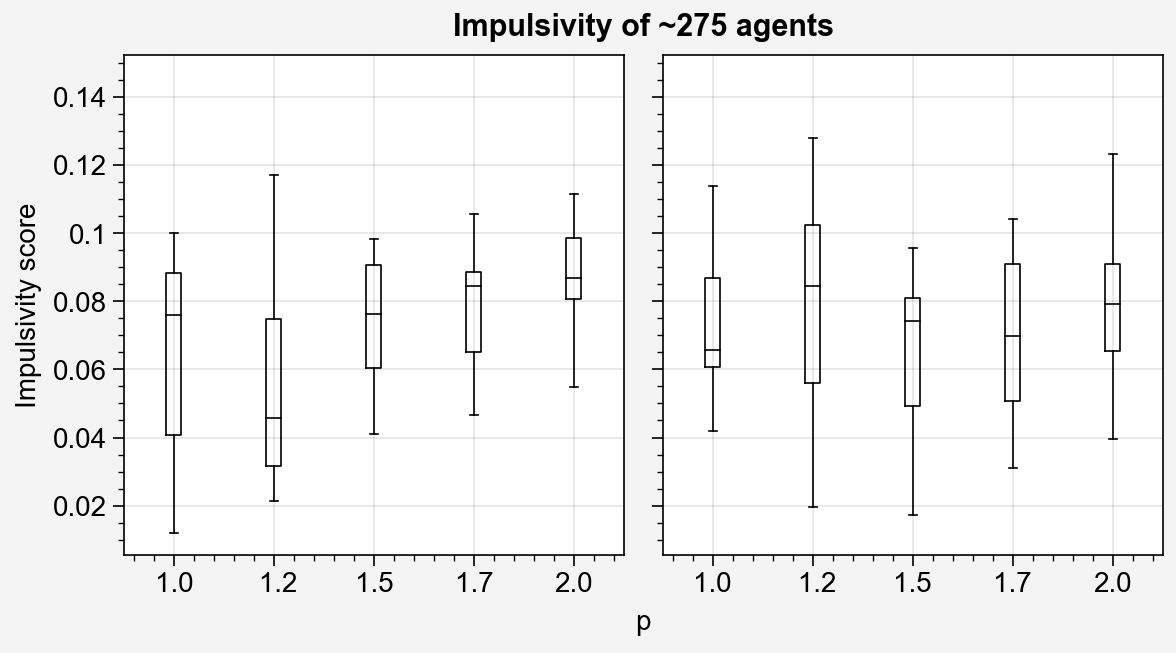

In [9]:
imp_scores = res['unconfidence_scores']
imp_scores = select_idxs(imp_scores, 'close')
fig, ax = pplt.subplots(ncols=2)
for h in range(2):
    for j in range(5):
        ax[h].boxplot(j, imp_scores[h, :, j, :].reshape(-1), fliers=False)
ax.format(xlabel=p_axis, xlocator=range(5), xformatter=p_labels,
          ylabel='Impulsivity score', suptitle='Impulsivity of ~275 agents')

p-value: 0.0922


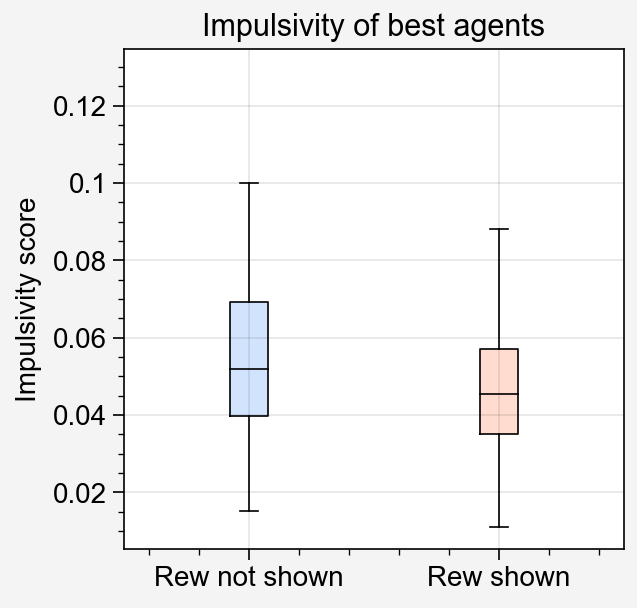

In [17]:
imp_scores = res['unconfidence_scores']
imp_scores = select_idxs(imp_scores)
fig, ax = pplt.subplots()
ys = []
for h in range(2):
    y = imp_scores[h, :, :, :].reshape(-1)
    ys.append(y)
    ax.boxplot(h, y, fliers=False, cycle=rgb_colors[h])
print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
ax.format(xlocator=range(2), xformatter=give_labels,
          ylabel='Impulsivity score', title='Impulsivity of best agents')

p-value: 0.1465


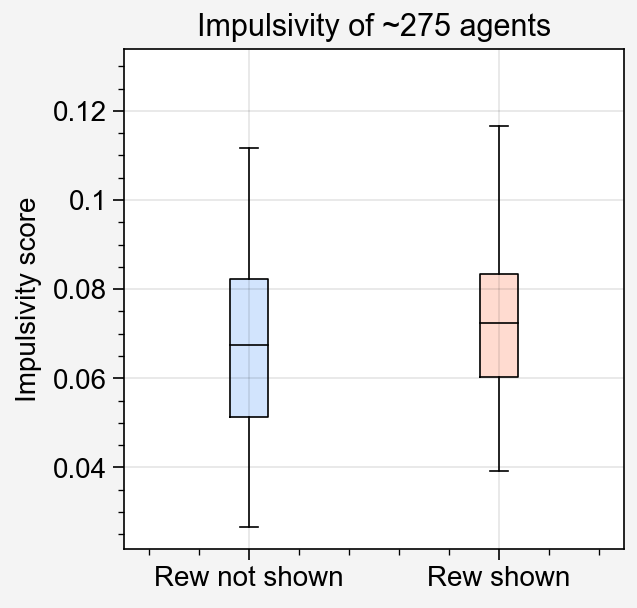

In [4]:
imp_scores = res['unconfidence_scores']
imp_scores = select_idxs(imp_scores, 'first')
fig, ax = pplt.subplots()
ys = []
for h in range(2):
    y = imp_scores[h, :, :, :].reshape(-1)
    ys.append(y)
    ax.boxplot(h, y, fliers=False, cycle=rgb_colors[h])
print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
ax.format(xlocator=range(2), xformatter=give_labels,
          ylabel='Impulsivity score', title='Impulsivity of ~275 agents')

## Relation between general impulsivity and value

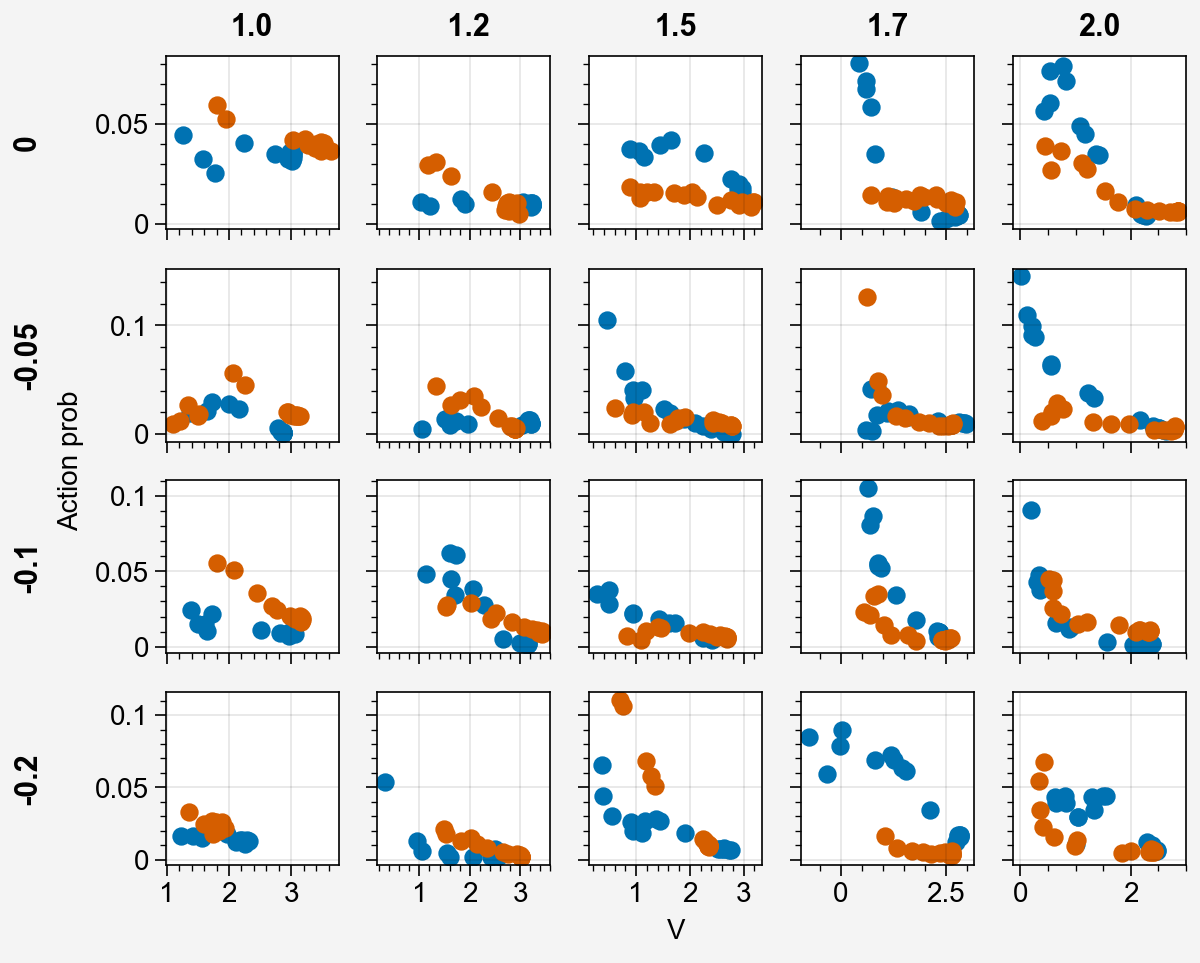

In [42]:
values = res['values']
all_lens = res['all_lens']
action_probs = res['action_probs']

best_idxs = pickle.load(open('data/meta_representation_best_idxs', 'rb'))
fig, ax = pplt.subplots(nrows=4, ncols=5, figwidth=6)
t = 1
for i in range(4):
    for j in range(5):
        for h in range(2):
            plot_v = []
            plot_ap = []
            for ep in range(17):
                idx = best_idxs[h, i, j, t]
                l = int(all_lens[h, i, j, t, idx, ep])
                v = values[h, i, j, t, idx, ep, :l]
                ap = action_probs[h, i, j, t, idx, ep, :l]
                plot_v.append(v[ap < 0.2].mean())
                plot_ap.append(ap[ap < 0.2].mean())
            ax[i, j].scatter(plot_v, plot_ap, label=give_labels[h])
            
ax.format(toplabels=p_labels, leftlabels=pop_labels, xlabel='V', ylabel='Action prob')

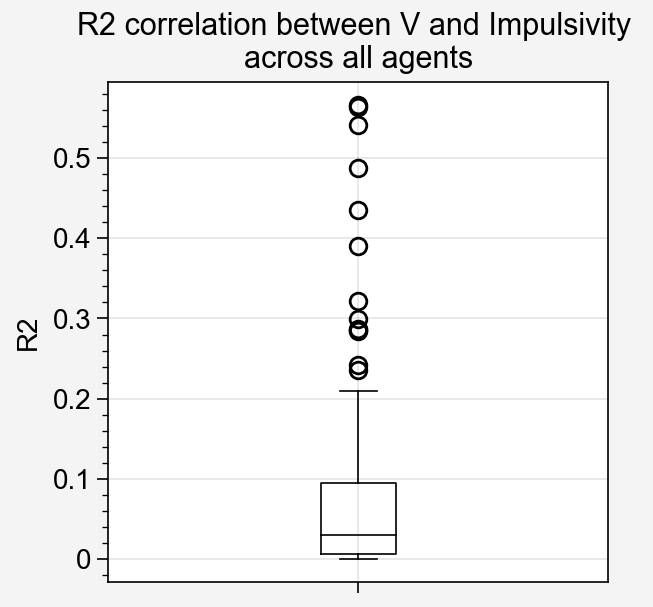

In [63]:
values = res['values']
all_lens = res['all_lens']
action_probs = res['action_probs']

best_idxs = pickle.load(open('data/meta_representation_best_idxs', 'rb'))
t = 1
r2s = []
idxs = []
for i in range(4):
    for j in range(5):
        for h in range(2):
            for t in range(3):
                vs = []
                aps = []
                for ep in range(17):
                    idx = best_idxs[h, i, j, t]
                    l = int(all_lens[h, i, j, t, idx, ep])
                    v = values[h, i, j, t, idx, ep, :l]
                    ap = action_probs[h, i, j, t, idx, ep, :l]
                    vs.append(v)
                    aps.append(ap)
                vs = np.concatenate(vs)
                aps = np.concatenate(aps)
                (_, _), r2 = linear_best_fit(vs[aps < 0.2], aps[aps < 0.2])
                idxs.append((h, i, j, t, idx))
                r2s.append(r2)

fig, ax = pplt.subplots()
ax.boxplot(r2s)
ax.format(xformatter=[''], ylabel='R2', title='R2 correlation between V and Impulsivity \nacross all agents')

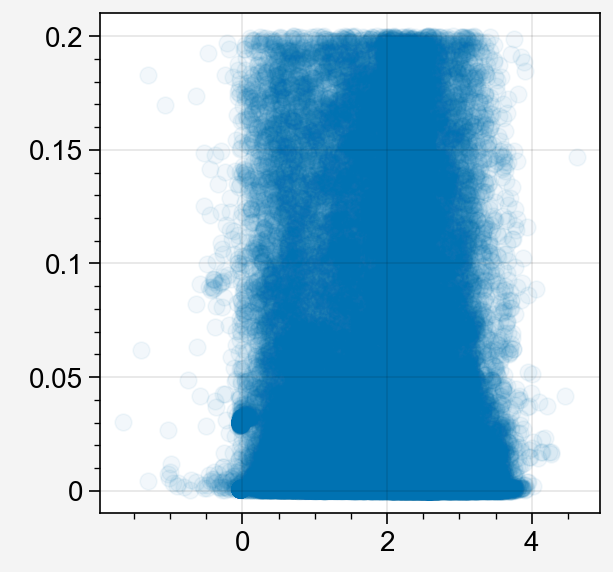

In [163]:
values = r['values']
all_lens = r['all_lens']
action_probs = r['action_probs']

fig, ax = pplt.subplots()
plot_v = []
plot_imp = []

for h, i, j, k, l in itertools.product(*iterators_idxs):
    for ep in range(17):
        lens = int(all_lens[h, i, j, k, l, ep])
        v = values[h, i, j, k, l, ep, :lens]
        ap = action_probs[h, i, j, k, l, ep, :lens]
        imp_steps = ap < 0.2
        plot_v.append(v[imp_steps])
        plot_imp.append(ap[imp_steps])
        
plot_v, plot_imp = np.concatenate(plot_v), np.concatenate(plot_imp)
idxs = np.random.permutation(len(plot_v))[:100000]

ax.scatter(plot_v[idxs], plot_imp[idxs], alpha=0.05)

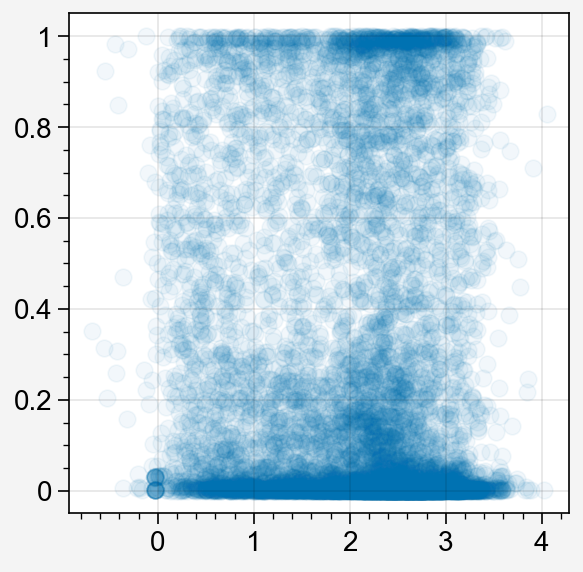

In [167]:
values = r['values']
all_lens = r['all_lens']
action_probs = r['action_probs']

fig, ax = pplt.subplots()
plot_v = []
plot_imp = []

for h, i, j, k, l in itertools.product(*iterators_idxs):
    for ep in range(17):
        lens = int(all_lens[h, i, j, k, l, ep])
        v = values[h, i, j, k, l, ep, :lens]
        ap = action_probs[h, i, j, k, l, ep, :lens]
        plot_v.append(v)
        plot_imp.append(ap)
plot_v, plot_imp = np.concatenate(plot_v), np.concatenate(plot_imp)
idxs = np.random.permutation(len(plot_v))[:10000]

ax.scatter(plot_v[idxs], plot_imp[idxs], alpha=0.05)

# Looking for another impulsivity metric

In [3]:
size = np.arange(0.2, 1.01, 0.05)
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0,
                            'fix_sizes': [0, s, 0]} for s in size]

evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)

model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p1.5n50_2/150.pt') #Agent A
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p1.5n50_1/150.pt') #Agent B
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p2.0n50pop0.1_2/240.pt') #Agent C
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p1.5n50pop0.1_2/50.pt') #Agent C
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p1.7n50pop0.1_1/100.pt') #Agent C
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=50)
# plot_1colornfsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


In [4]:
give_rew = ['', 'giverew_']
postfixes = ['', 'pop0.05', 'pop0.1', 'pop0.2']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = np.arange(10, 243, 30)

give_labels = ['Rew not shown', 'Rew shown']
pop_labels = ['0', '-0.05', '-0.1', '-0.2']
pop_vals = [0, -0.05, -0.1, -0.2]
p_labels = ['1.0',' 1.2', '1.5', '1.7', '2.0']
chk_labels = [str(c) for c in chks]
chk_axis = 'Checkpoint'
pop_axis = 'Punishment on pop'
p_axis = 'p'

iterators = [give_rew, postfixes, models, trials, chks]
# iterators = [postfixes, models, trials, chks]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

res = pickle.load(open('data/meta_representation_results', 'rb'))

def metabart_model_load(h, i, j, k, l=None, by='first'):
    give_rew = ['', 'giverew_']
    postfixes = ['', 'pop0.05', 'pop0.1', 'pop0.2']
    models = [1.0, 1.2, 1.5, 1.7, 2.0]
    trials = range(3)
    chks = np.arange(10, 243, 30)

    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    
    if l is None:    
        if by == 'best':
            idxs = pickle.load(open('data/meta_representation_best_idxs', 'rb'))
        elif by == 'first': 
            idxs = pickle.load(open('data/meta_representation_first_idxs', 'rb'))
        elif by == 'close': 
            idxs = pickle.load(open('data/meta_representation_close_idxs', 'rb'))
        chk = chks[idxs[h, i, j, t]]
    else:
        chk = chks[l]

    
    if h == 1 and postfix == '':
        postfix = 'pop0'
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')

    return model, obs_rms

    
size = np.arange(0.2, 1.01, 0.05)
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0,
                            'fix_sizes': [0, s, 0]} for s in size]
give_env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0, 'give_rew': True,
                            'fix_sizes': [0, s, 0]} for s in size]

evalu_ = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)
give_evalu_ = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=give_env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)


def evalu(model, obs_rms, give_rew=False):
    if give_rew:
        res = give_evalu_(model, obs_rms)
    else:
        res = evalu_(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=50)
    return res

def select_random_model(size=1, by='first', seed=None, load_models=False):
    '''
    Randomly select a tested model, picking a specific checkpoint
    corresponding to by: 'first'/'best'/'close'
    '''
    if by == 'best':
        idxs = pickle.load(open('data/meta_representation_best_idxs', 'rb'))
    elif by == 'first': 
        idxs = pickle.load(open('data/meta_representation_first_idxs', 'rb'))
    elif by == 'close': 
        idxs = pickle.load(open('data/meta_representation_close_idxs', 'rb'))
    total_size = np.prod(idxs.shape)
    models = np.random.choice(np.arange(total_size), size=size, replace=False)
    models = [np.unravel_index(model, idxs.shape) for model in models]
    model_idxs = [model + (idxs[model],) for model in models]

    if load_models:
        models = []
        obs_rmss  = []
        rs = []
        for idx in model_idxs:
            h, i, j, t, chk = idx       
            model, obs_rms = metabart_model_load(h, i, j, t, chk)
            give_rew = True if h == 1 else False
            print(h, give_rew)
            
            r = evalu(model, obs_rms, give_rew)
            models.append(model)
            obs_rmss.append(obs_rms)
            rs.append(r)
        return model_idxs, models, obs_rmss, rs
    return model_idxs

    

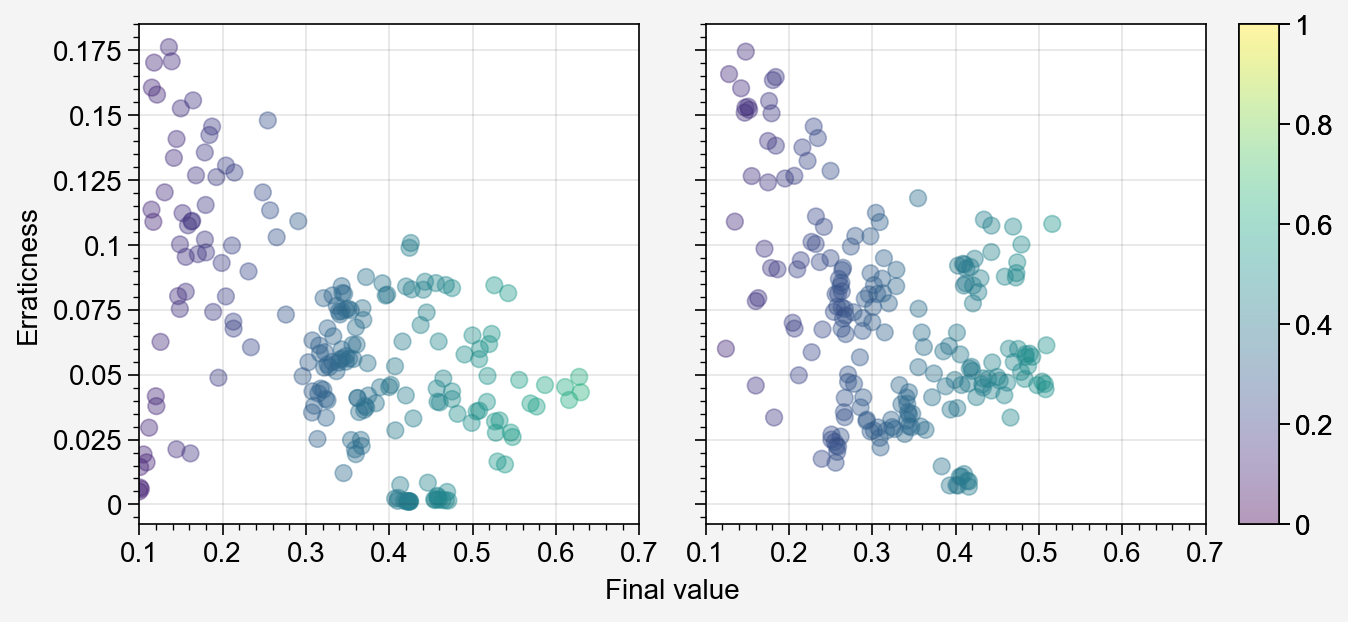

In [8]:
fig, ax = pplt.subplots(ncols=2)
all_final_vs = []
all_final_errs = []
all_bsizes = []

for i in range(2):
    idxs = select_chks_by_dimension(h=i, j=0)
    for idx in idxs:
        bsizes = [np.mean(b[b != 0]) for b in res['last_sizes'][idx]]
        lens = res['all_lens'][idx]
        values = res['values'][idx]
        action_probs = res['action_probs'][idx]

        final_vs = []
        final_errs = []
        for ep in range(17):
            l = int(lens[ep])
            v = values[ep][:l]
            ap = action_probs[ep][:l]
            steps = np.arange(len(ap))
            imp_steps = ap < 0.5
            x = steps[imp_steps]
            smoothed_ap = pd.Series(ap[imp_steps]).ewm(alpha=0.01).mean()
            smoothed_v = pd.Series(v[imp_steps]).ewm(alpha=0.01).mean()
            final_vs.append(smoothed_v.iloc[-1])
            final_errs.append(smoothed_ap.iloc[-1])
        # cb = ax.scatter(final_vs, final_errs, c=bsizes, cmap='Viridis', vmin=0, vmax=1,
        #                 alpha=0.4)
        cb = ax[i].scatter(bsizes, final_errs, c=bsizes, cmap='Viridis', vmin=0, vmax=1,
                        alpha=0.4)
        all_final_vs.append(final_vs)
        all_final_errs.append(final_errs)
        all_bsizes.append(bsizes)

ax[1].colorbar(cb)
ax.format(xlabel='Final value', ylabel='Erraticness')
ax.format(xlim=[0.1, 0.7])

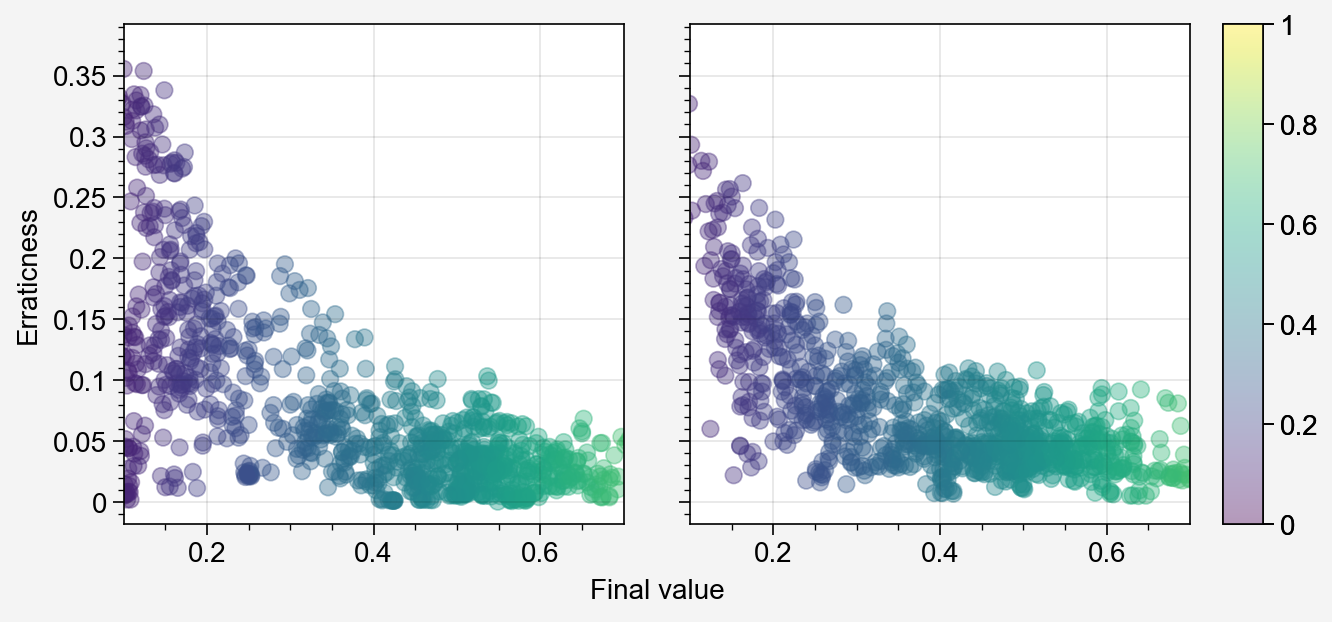

In [12]:
fig, ax = pplt.subplots(ncols=2)
all_final_vs = []
all_final_errs = []
all_bsizes = []

for i in range(2):
    idxs = select_chks_by_dimension(h=i)
    for idx in idxs:
        bsizes = [np.mean(b[b != 0]) for b in res['last_sizes'][idx]]
        lens = res['all_lens'][idx]
        values = res['values'][idx]
        action_probs = res['action_probs'][idx]

        final_vs = []
        final_errs = []
        for ep in range(17):
            l = int(lens[ep])
            v = values[ep][:l]
            ap = action_probs[ep][:l]
            steps = np.arange(len(ap))
            imp_steps = ap < 0.5
            x = steps[imp_steps]
            smoothed_ap = pd.Series(ap[imp_steps]).ewm(alpha=0.01).mean()
            smoothed_v = pd.Series(v[imp_steps]).ewm(alpha=0.01).mean()
            final_vs.append(smoothed_v.iloc[-1])
            final_errs.append(smoothed_ap.iloc[-1])
        # cb = ax.scatter(final_vs, final_errs, c=bsizes, cmap='Viridis', vmin=0, vmax=1,
        #                 alpha=0.4)
        cb = ax[i].scatter(bsizes, final_errs, c=bsizes, cmap='Viridis', vmin=0, vmax=1,
                        alpha=0.4)
        all_final_vs.append(final_vs)
        all_final_errs.append(final_errs)
        all_bsizes.append(bsizes)

ax[1].colorbar(cb)
ax.format(xlabel='Final value', ylabel='Erraticness')
ax.format(xlim=[0.1, 0.7])

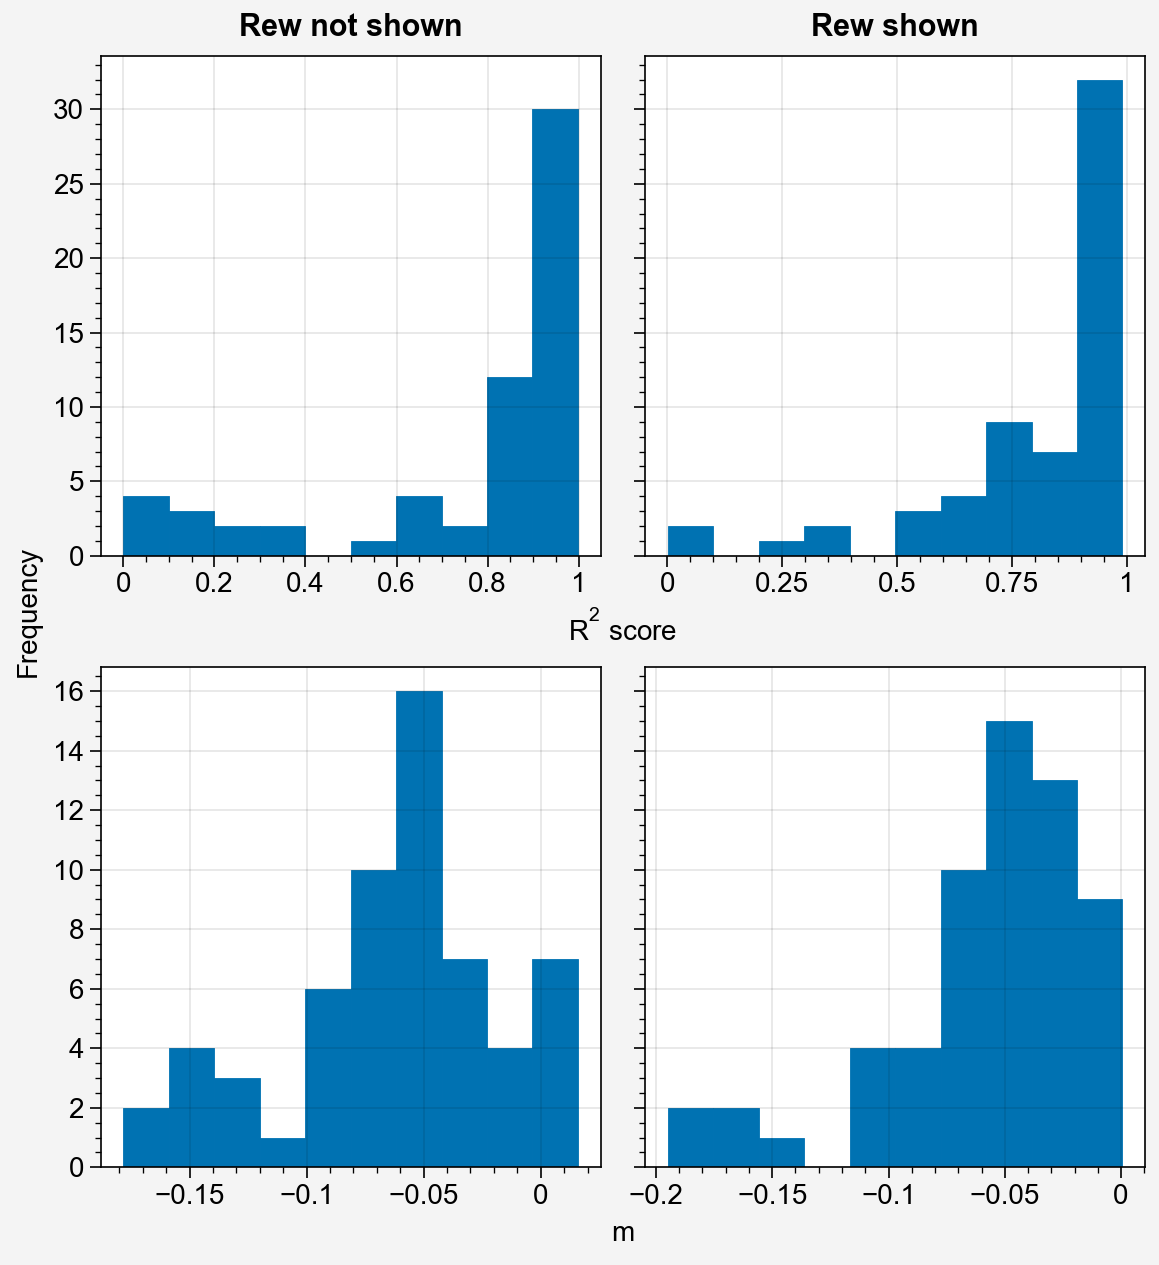

In [81]:
fig, ax = pplt.subplots(nrows=2, ncols=2, sharex=False, spanx=True)

for i in range(2):
    idxs = select_chks_by_dimension(h=i)
    slopes = []
    r2s = []
    for idx in idxs:
        r = get_data_from_summary(res, idx)
        x, y = np.array(r['final_v']), np.array(r['final_err'])
        (m, b), r2 = linear_best_fit(x, y)
        slopes.append(m)
        r2s.append(r2)
    ax[0, i].hist(r2s)
    ax[1, i].hist(slopes)
ax.format(ylabel='Frequency', toplabels=give_labels,
          suptitle='')
ax[0, 0].format(xlabel='$R^2$ score')
ax[1, 0].format(xlabel='m')

In [80]:
h = 0
i = 0
j = 4
t = 1
model, obs_rms = metabart_model_load(h, i, j, t)
r = evalu(model, obs_rms)
agent_label = f'{give_labels[h]}, p={p_labels[j]}, pop {pop_labels[i]}'

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


KeyError: 'data'

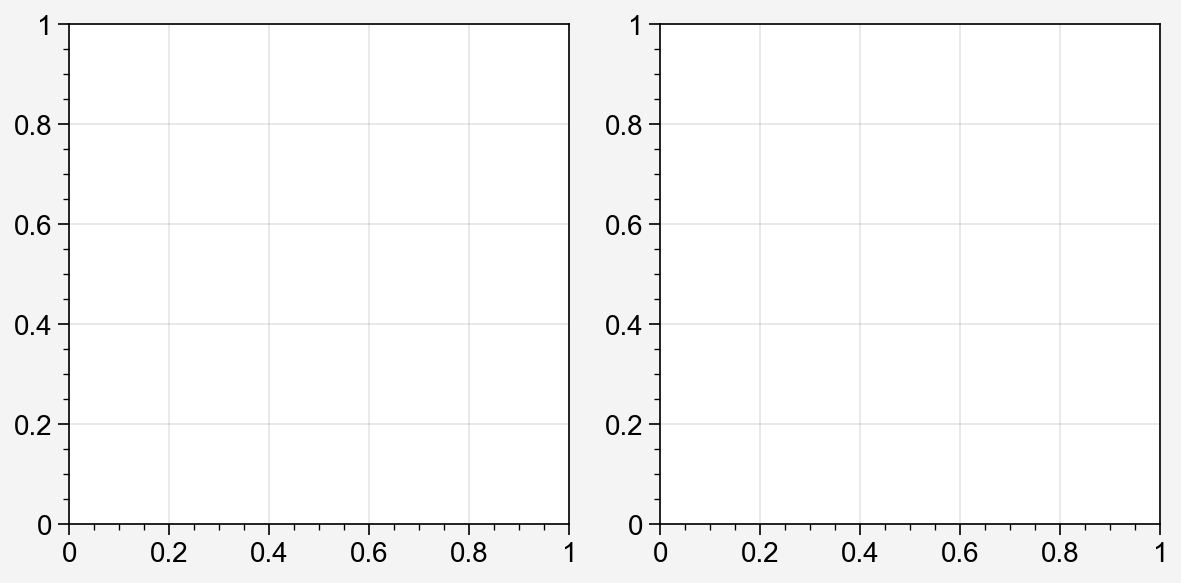

In [82]:
fig, ax = pplt.subplots(ncols=2, sharey=False)

bsizes = []
for ep in range(17):
    popped = np.array(r['data']['popped'][ep])
    sizes = np.array(r['data']['last_size'][ep])
    bsizes.append(np.mean(sizes[~popped]))
vmin = np.min(bsizes)
vmax = np.max(bsizes) + 0.05

for j, ep in enumerate(range(17)):
    ap = r['action_probs'][ep][:, 1]
    steps = np.arange(len(ap))
    imp_steps = ap < 0.5
    x = steps[imp_steps]
    smoothed_ap = pd.Series(ap[imp_steps]).ewm(alpha=0.01).mean()
    s = bsizes[j]
    c = get_color_from_colormap(s, vmin, vmax, to_hex=False)
    ax[0].plot(x, smoothed_ap, c=c, alpha=0.5)
    
ax[0].format(xlabel='time step', ylabel='Uncertainty')
ax.format(suptitle=agent_label)
visualize_episode_values(r, ax=ax[1])


In [81]:

np.mean(r['data']['popped'][0])

0.16

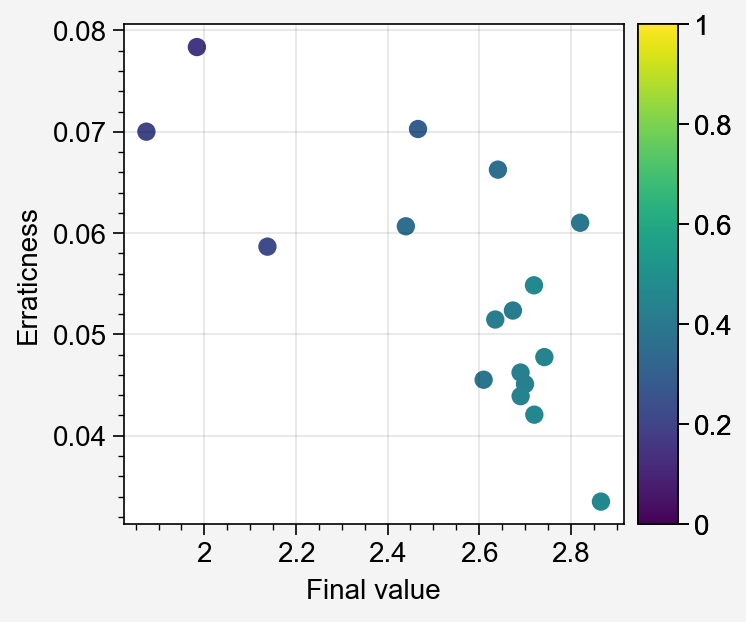

In [36]:
idx = random.choice(idxs)
bsizes = [np.mean(b[b != 0]) for b in res['last_sizes'][idx]]
lens = res['all_lens'][idx]
values = res['values'][idx]
action_probs = res['action_probs'][idx]

final_vs = []
final_errs = []
for ep in range(17):
    l = int(lens[ep])
    v = values[ep][:l]
    ap = action_probs[ep][:l]
    steps = np.arange(len(ap))
    imp_steps = ap < 0.5
    x = steps[imp_steps]
    smoothed_ap = pd.Series(ap[imp_steps]).ewm(alpha=0.01).mean()
    smoothed_v = pd.Series(v[imp_steps]).ewm(alpha=0.01).mean()
    final_vs.append(smoothed_v.iloc[-1])
    final_errs.append(smoothed_ap.iloc[-1])

fig, ax = pplt.subplots()
cb = ax.scatter(final_vs, final_errs, c=bsizes, cmap='Viridis', vmin=0, vmax=1)
ax.colorbar(cb)
ax.format(xlabel='Final value', ylabel='Erraticness')

In [84]:
idx

(1, 3, 4, 2, 1)

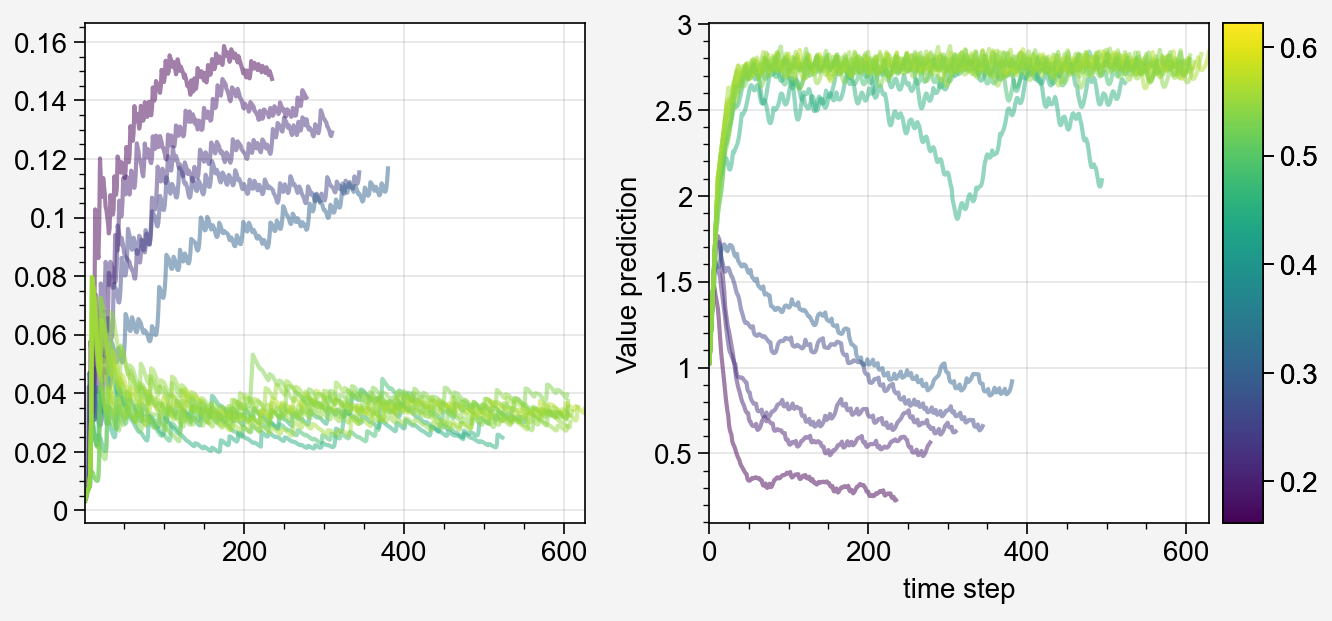

In [83]:
visualize_episode_values_from_summary(res, idx)

In [83]:
h = 1
i = 0
j = 0
t = 1
model, obs_rms = metabart_model_load(h, i, j, t)
r = evalu(model, obs_rms, True)
agent_label = f'{give_labels[h]}, p={p_labels[j]}, pop {pop_labels[i]}'

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


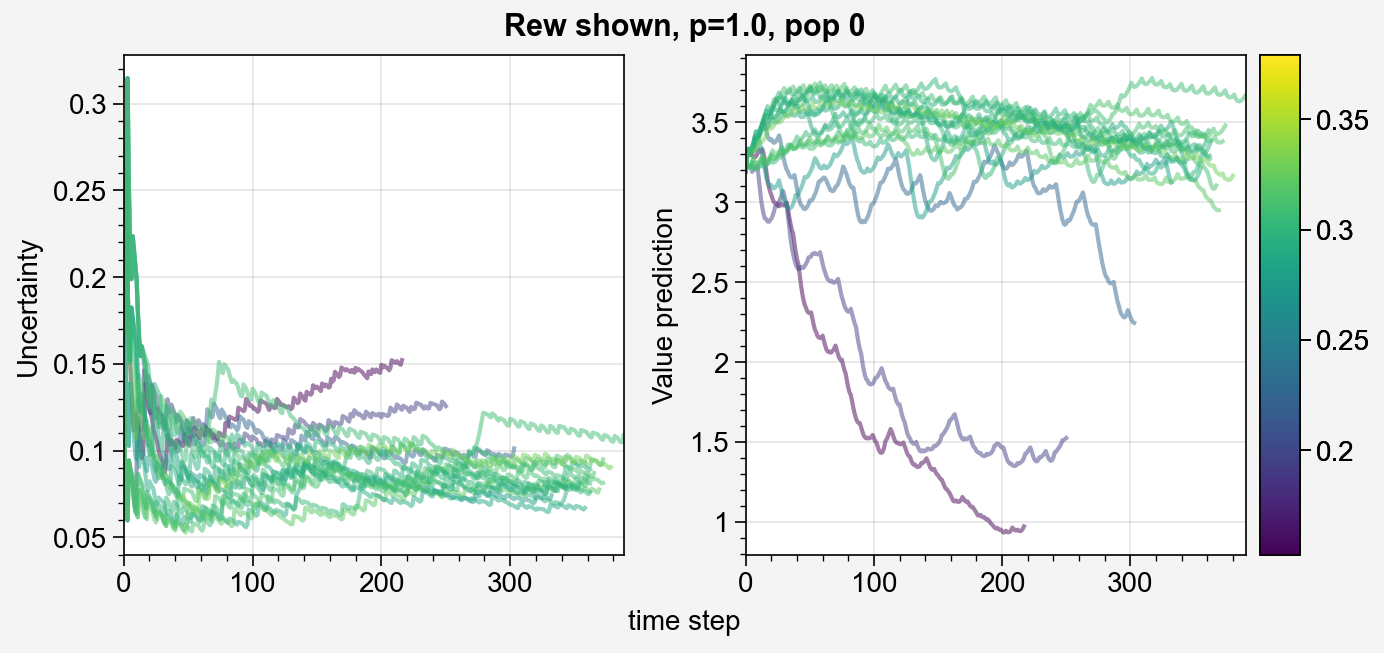

In [75]:
fig, ax = pplt.subplots(ncols=2, sharey=False)

bsizes = []
for ep in range(17):
    popped = np.array(r['data']['popped'][ep])
    sizes = np.array(r['data']['last_size'][ep])
    bsizes.append(np.mean(sizes[~popped]))
vmin = np.min(bsizes)
vmax = np.max(bsizes) + 0.05

for j, ep in enumerate(range(17)):
    ap = r['action_probs'][ep][:, 1]
    steps = np.arange(len(ap))
    imp_steps = ap < 0.5
    x = steps[imp_steps]
    smoothed_ap = pd.Series(ap[imp_steps]).ewm(alpha=0.01).mean()
    s = bsizes[j]
    c = get_color_from_colormap(s, vmin, vmax, to_hex=False)
    ax[0].plot(x, smoothed_ap, c=c, alpha=0.5)
    
ax[0].format(xlabel='time step', ylabel='Uncertainty')
ax.format(suptitle=agent_label)
visualize_episode_values(r, ax=ax[1])
